# Machine Learning Project

# I. Introduction

Sequence classification is a type of predictive problem where we try to predict the category of a sequence of inputs over space or time. It is a hard task because the inputs can vary in length, the set of words (vocabulary) can be vary large and the model may want to understand the long-term context of a sequence.

## Description of the dataset

We will demonstrate sequence learning through a twitter sentiment analysis classification problem. Each tweet are short messages of varied length of words and the task is to build a classifier that can correctly predict the sentiment of each tweet.
Our dataset contains more than 1.2 million tweets, equally split in positive and negative messages. 

## Approach

We will approach this classification task by first getting an overlook of the dataset and the kind of messages we have at hand. Then we will apply some NLP techniques to transform our data into numerical objects (embedding) which we will feed into various Machine Learning Models. From Logistic Regressions to Deep Learning models, we will compare them and create a benchmark of various Supervised models for this classification task.

## Import

### Libraries and modules

In [2]:
# Base tools
import numpy as np
from numpy import array, asarray, zeros
import pandas as pd
from pprint import pprint
from time import time
import logging
#from ipynb.fs.full.Functions import *  # Import all functions from the Functions notebook

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

sns.set(style="darkgrid")
sns.set(font_scale=1.3)
%matplotlib inline

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re, string

# Machine Learning
## Tools
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
## Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
import xgboost as xgb

# Deep Learning
import keras.backend as K
from keras import utils
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalMaxPooling1D, Conv1D, LSTM, Flatten, Dense, Embedding, MaxPooling1D, Activation, Dropout, Dense, Bidirectional
from keras.models import Sequential

### Dataset

In [3]:
emote = pd.read_csv("data/MLUnige2021_train.csv",index_col=0)

### Functions

In [4]:
def ratio_positive(user, df):
    positive_tweets = df[df["user"] == user]['emotion'].sum()
    total_tweets = len(df[df["user"] == user])
    return np.round(positive_tweets / total_tweets * 100, 2)


def ratio_positive_all(user, df):
    positive_tweets = df[df["user"] == user]['emotion'].sum()
    total_tweets = len(df[df["user"] == user])
    return positive_tweets, total_tweets, np.round(
        positive_tweets / total_tweets * 100, 2)


def GridSearch_(X,
                y,
                parameters,
                model,
                scoring=['accuracy', 'f1', 'precision', 'recall'],
                refit="accuracy",
                n_jobs=-1):
    '''Perform the grid search analysis with selected parameters set, model and data. Returns the grid search object with the
    set of best parameters'''
    # Create a pipeline with model
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('model', model),
    ])
    # Create a grid search object with parameters to test
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               scoring=scoring,
                               refit=refit,
                               n_jobs=n_jobs,
                               verbose=1)

    print("Performing grid search...")
    print()
    print("Data length: ", len(y))
    print("Pipeline:", ' '.join([str(_) for name, _ in pipeline.steps[:2]]),
          model)
    print()
    print("Parameters:")
    pprint(parameters)
    print()
    t0 = time()
    grid_search.fit(X, y)
    print("Duration: %0.1fs (n_jobs: %.f)" % ((time() - t0), n_jobs))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search


def make_results(model_name, size, model_object, metric='accuracy'):
    ''' Create dictionary that maps input metric to actual metric name in GridSearchCV'''

    metric_dict = {
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy',
    }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[
        cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame(
        {
            'model': [model_name],
            'size': [size],
            'precision': [precision],
            'recall': [recall],
            'F1': [f1],
            'accuracy': [accuracy],
        }, )

    return table

def make_results_dl(model_name, y_test, y_pred):
    # Extract accuracy, precision, recall, and f1 score from that row
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Create table of results
    table = pd.DataFrame(
        {
            'model': [model_name],
            'precision': [precision],
            'recall': [recall],
            'F1': [f1],
            'accuracy': [accuracy],
        }, )

    return table

# II. Exploratory Data Analysis & Feature Engineering

### First look at the data

Now that we've imported our training dataset, let's take a first look into it.

In [38]:
# Dataset shape
print("Dataset shape:", emote.shape)

# Dataset head
emote.head()

Dataset shape: (1280000, 6)


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...
1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...
2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...
3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...
4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...


This dataset contains not only the tweets and its corresponding emotions, but also the username of the sender, the date at which the tweet was sent and a last column which indicates if a specific query was used in processing the data. 

In [39]:
# Dataset info
emote.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280000 entries, 0 to 1279999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   emotion    1280000 non-null  int64 
 1   tweet_id   1280000 non-null  int64 
 2   date       1280000 non-null  object
 3   lyx_query  1280000 non-null  object
 4   user       1280000 non-null  object
 5   text       1280000 non-null  object
dtypes: int64(2), object(4)
memory usage: 68.4+ MB


###### Missing values

In [40]:
# Check missing emotions
print("Missing values in our data :", emote.isna().sum().sum())

# Check Query column
found = emote['lyx_query'].str.contains('NO_QUERY')
print("Instances of NO_QUERY in column 'lyx_query':", found.count())

Missing values in our data : 0
Instances of NO_QUERY in column 'lyx_query': 1280000


Our dataset doesn't contain any missing values. Moreover, we observe that the column 'lyx_query' is full of the same statement 'NO_QUERY'. Thus, this variable is of no use in the predictive aim of our model since it doesn't make any discrimination between any tweet.

###### Duplicates

In [41]:
# Unique tweets
print("Number of unique tweet id :", emote["tweet_id"].nunique())

# Number of duplicates
print('Number of duplicated tweets: ', emote["tweet_id"].duplicated().sum()) # Sums to 128000 with other unique ones, so no more than 1 copy per duplicated tweet

# Check duplicates
display(emote[emote["tweet_id"].duplicated()].head(3))

# Check copy of duplicated tweets
display(emote[emote['tweet_id'] == 2178343280])

Number of unique tweet id : 1278931
Number of duplicated tweets:  1069


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
18483,0,2178343280,Mon Jun 15 07:33:43 PDT 2009,NO_QUERY,Dimonios,@ontd30stm http://bit.ly/2yn5l7 Delicious th...
40648,0,1990826216,Mon Jun 01 05:49:56 PDT 2009,NO_QUERY,SophieAndrea,@fordiddy tell me about it. because it's my l...
52008,1,2182706647,Mon Jun 15 13:31:41 PDT 2009,NO_QUERY,conorjryan,knowing me I'll tweet as soon as I get one and...


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
13405,1,2178343280,Mon Jun 15 07:33:43 PDT 2009,NO_QUERY,Dimonios,@ontd30stm http://bit.ly/2yn5l7 Delicious th...
18483,0,2178343280,Mon Jun 15 07:33:43 PDT 2009,NO_QUERY,Dimonios,@ontd30stm http://bit.ly/2yn5l7 Delicious th...


In [42]:
# Remove duplicates
emote = emote.drop_duplicates(subset='tweet_id')
print('New dataframe size: ', emote.shape)

New dataframe size:  (1278931, 6)


###### Users 

In [43]:
# Check unique users
print("Number of unique users :", emote["user"].nunique())

Number of unique users : 574114


In [44]:
# Users message distribution
print("Users and tweets count :")
print(emote["user"].value_counts()) # some of them commented a lot
print()
tweeted_once = sum(emote["user"].value_counts() == 1)
print("Number of users that tweeted only once: {} ({}%)".format(tweeted_once,round(tweeted_once/len(emote)*100,2)))

Users and tweets count :
lost_dog         446
webwoke          292
tweetpet         239
VioletsCRUK      234
mcraddictal      226
                ... 
mfitzii            1
julianchansax      1
Antmfan227         1
jaymieg            1
JonesTheFilm       1
Name: user, Length: 574114, dtype: int64

Number of users that tweeted only once: 365638 (28.59%)


About a quarter of the twitter users in our training dataset only tweeted once during that period, while some of them went as far as tweeting several hundred times.

###### Emotions

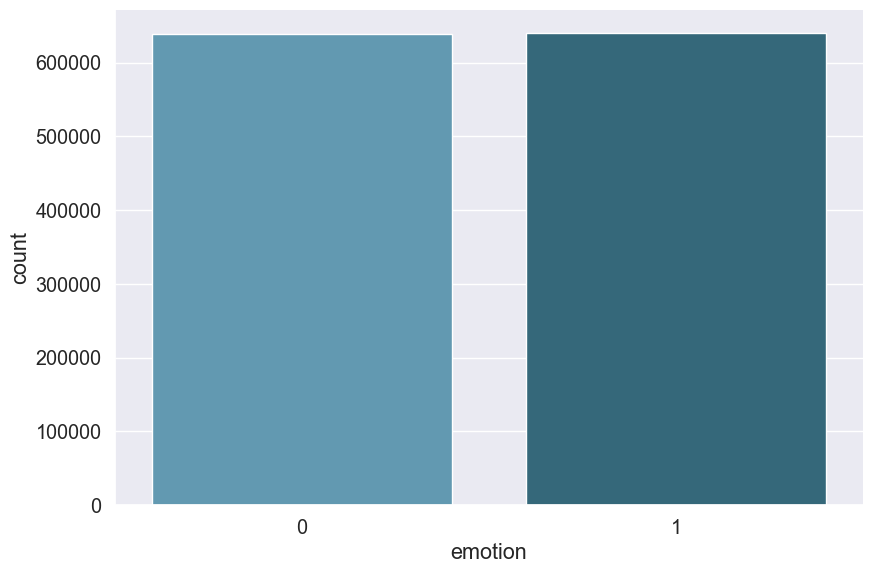

Number of positive tweets : 639564
Number of negative tweets : 639367


In [45]:
# Plot positive & negative tweets
sns.catplot(x="emotion", data=emote, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

# Sum of positive & negative tweets
print("Number of positive tweets :", sum(emote["emotion"] == 1))
print("Number of negative tweets :", sum(emote["emotion"] == 0))

We are training on a pretty balanced dataset with as much positive and negative tweets. This will let us perform train/test split without the need of stratifying.

### 5 Most talkative users data

#### lost_dog

In [46]:
# User who tweeted the most
user = 'lost_dog'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 0/446 (0.0%)


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
8229,0,2209419659,Wed Jun 17 10:22:06 PDT 2009,NO_QUERY,lost_dog,@JamieDrokan I am lost. Please help me find a ...
9527,0,2328965183,Thu Jun 25 10:11:34 PDT 2009,NO_QUERY,lost_dog,@W_Hancock I am lost. Please help me find a go...
10645,0,2072079020,Sun Jun 07 20:21:54 PDT 2009,NO_QUERY,lost_dog,@miznatch I am lost. Please help me find a goo...
14863,0,2214285766,Wed Jun 17 16:31:38 PDT 2009,NO_QUERY,lost_dog,@kgustafson I am lost. Please help me find a g...
16723,0,1696136174,Mon May 04 07:41:03 PDT 2009,NO_QUERY,lost_dog,@kneeon I am lost. Please help me find a good ...


lost_dog is definitely a spam bot, all the 446 messages seem to be identical: "@random_user I am lost. Please help me find a good home."

#### webwoke

In [47]:
user = 'webwoke'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 68/292 (23.29%)


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
19553,0,2067697514,Sun Jun 07 12:48:05 PDT 2009,NO_QUERY,webwoke,come on... drop by 1 44. blogtoplist.com
24144,0,2072285184,Sun Jun 07 20:44:08 PDT 2009,NO_QUERY,webwoke,"owww god, drop by 18 57. blogspot.com"
25988,0,2055206809,Sat Jun 06 08:54:04 PDT 2009,NO_QUERY,webwoke,F**K! drop by 1 97. zimbio.com
28219,1,2053451192,Sat Jun 06 04:36:04 PDT 2009,NO_QUERY,webwoke,uhuiii... move up by 1 69. hubpages.com
28597,1,2066463084,Sun Jun 07 10:34:05 PDT 2009,NO_QUERY,webwoke,GoGoGo... move up by 1 13. slideshare.net


Looks like webwoke is a spam bot making a request to visit some random website.

#### tweetpet

In [48]:
user = 'tweetpet'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 0/239 (0.0%)


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
11130,0,1676425868,Fri May 01 22:00:38 PDT 2009,NO_QUERY,tweetpet,@CeladonNewTown Clean Me!
13494,0,1573611322,Tue Apr 21 02:00:03 PDT 2009,NO_QUERY,tweetpet,@chromachris Clean Me!
17443,0,1676426980,Fri May 01 22:00:49 PDT 2009,NO_QUERY,tweetpet,@Kamryn6179 Clean Me!
23973,0,1677423044,Sat May 02 02:00:12 PDT 2009,NO_QUERY,tweetpet,@greenbizdaily Clean Me!
33463,0,1676426375,Fri May 01 22:00:43 PDT 2009,NO_QUERY,tweetpet,@ANALOVESTITO Clean Me!


Tweetpet messages also all seem to be identical, it is probably a bot sending notifications to specific users.

#### VioletsCRUK

In [49]:
user = 'VioletsCRUK'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 180/234 (76.92%)


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
8319,0,2057611341,Sat Jun 06 13:19:41 PDT 2009,NO_QUERY,VioletsCRUK,@marginatasnaily lol i was chucked of 4 times ...
9102,1,1573700635,Tue Apr 21 02:26:06 PDT 2009,NO_QUERY,VioletsCRUK,@highdigi Nothing worse! Rain has just started...
16570,1,1980137710,Sun May 31 05:49:01 PDT 2009,NO_QUERY,VioletsCRUK,Will catch up with yas later..goin for a solid...
37711,1,1881181047,Fri May 22 03:52:11 PDT 2009,NO_QUERY,VioletsCRUK,@Glasgowlassy lol oh that's a big buffet of ha...
37909,0,2067636547,Sun Jun 07 12:41:40 PDT 2009,NO_QUERY,VioletsCRUK,@jimkerr09 That was a really lovely tribute to...


VioletsCRUK seems to be our most active user that is not a bot, with a high ratio of positive and varied messages.

#### mcraddictal

In [50]:
user = 'mcraddictal'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 54/226 (23.89%)


,emotion,tweet_id,date,lyx_query,user,text
Id,,,,,,
2337,0,2059074446,Sat Jun 06 16:11:42 PDT 2009,NO_QUERY,mcraddictal,@MyCheMicALmuse pleaseeee tell me? -bites nail...
2815,0,1968268387,Fri May 29 21:05:43 PDT 2009,NO_QUERY,mcraddictal,@MCRmuffin
7448,0,2052420061,Sat Jun 06 00:40:11 PDT 2009,NO_QUERY,mcraddictal,@chemicalzombie dont make me say it you know.
10092,0,2061250826,Sat Jun 06 20:29:01 PDT 2009,NO_QUERY,mcraddictal,@NoRaptors noooooo begging i hate that. I'm s...
13533,0,1981070459,Sun May 31 08:20:52 PDT 2009,NO_QUERY,mcraddictal,@Boy_Kill_Boy so was haunting in ct. That mov...


mcRaddictal seems to also be a common user with varied text messages, this time mostly negative tweets.

Out of the 5 users that tweeted the most, it seems like 3 of them are some kind of bot or spam bot. The 4th and 5th ones seem to be random users from which we got a lot tweets in the database.
All these users show pattern in the tweets the sent, they all have either a high positive or high negative emotion count. 'Lost_dog' and 'tweetpet' both sent only negative tweets out of hundreds of them. 'webwoke' and 'mcraddictal' also sent largely negative tweets while 'VioletsCRUK' sent mostly positive tweets. We'll take this information into account when building our classifier.

###### Date

In [51]:
print('Earliest tweet: ', min(emote['date']))
print('Latest tweet: ', max(emote['date']))


Earliest tweet:  Fri Apr 17 20:30:31 PDT 2009
Latest tweet:  Wed May 27 07:27:38 PDT 2009


In [52]:
################################# Further work needed #################################################
#from datetime import * # !!! Makes time() function fail in the gridsearch algorithm

dt = min(emote['date'])
print(min(emote['date']))
date_format = '%a %b %d %I:%M:%S %Z %Y'
#date_format = '%a %b %d %X %Z %Y'
#date_format = "%c"

#datetime.strptime(dt, date_format)
# Issue: strptime %z doesn't take PDT as a timezone, only GMT and UTC, changing all the dates takes a bit 
# of time, altough could improve model, will check later

# SHOULD HAVE WORKED LIKE THIS
date_str = '02/28/2023 02:30 PM'
date_format = '%m/%d/%Y %I:%M %p'
#datetime.strptime(date_str, date_format)
# from time import time
################################# Further work needed #################################################

Fri Apr 17 20:30:31 PDT 2009


###### Tweet length

Shortest tweet length: 2
Largest tweet length: 110


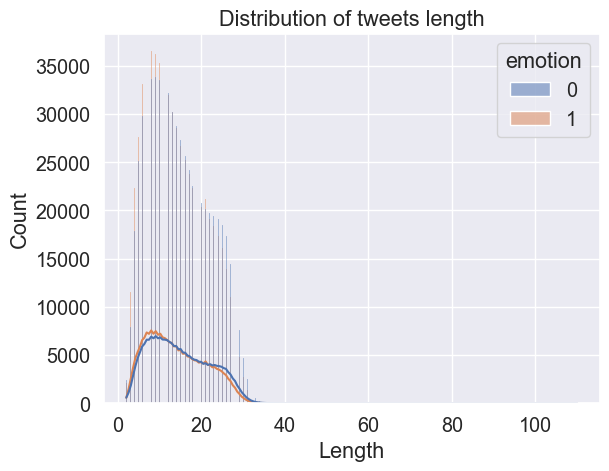

In [53]:
# Distribution of tweets length
emote['length'] = emote['text'].apply(lambda x: len(x.split(' ')))
print('Shortest tweet length:', min(emote['length']))
print('Largest tweet length:', max(emote['length']))
sns.histplot(data=emote, x='length', hue='emotion', kde=True)
plt.xlabel('Length');
plt.title('Distribution of tweets length');

### Symbols
Make text lowercase, remove text in square brackets, remove links, remove punctuation, and remove words containing numbers:

In [54]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [55]:
# Create a clean text column
emote['text_clean'] = emote['text'].apply(clean_text)
emote.head(3)

,emotion,tweet_id,date,lyx_query,user,text,length,text_clean
Id,,,,,,,,
0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...,10,breeme more time to play with you blackberry t...
1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...,27,failed attempt at booting to a flash drive the...
2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...,23,msproductions well aint that the truth whered ...


### Stopwords
Remove stopwords (a list of not useful english words like 'the', 'at', etc.). It allows us to reduce dimension of the data when tokenizing.

In [56]:
# Define the stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

# Remove stopwords
emote['text_clean'] = emote['text_clean'].apply(remove_stopwords)
emote.head()

,emotion,tweet_id,date,lyx_query,user,text,length,text_clean
Id,,,,,,,,
0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...,10,breeme time play blackberry
1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...,27,failed attempt booting flash drive failed atte...
2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...,23,msproductions well aint truth whered damn auto...
3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...,15,meaghery cheers craig really sweet reply pumped
4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...,29,reading tweets got send lying phone face dropp...


### Stemming/ Lematization

Stemming cuts off prefixes and suffixes (ex: laziness -> lazi). Lemma converts words (ex: writing, writes) into its radical (ex: write).

In [57]:
# Initiate stemmer
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [58]:
# Apply stemming
emote['text_clean'] = emote['text_clean'].apply(stemm_text)
emote.head()

,emotion,tweet_id,date,lyx_query,user,text,length,text_clean
Id,,,,,,,,
0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...,10,breem time play blackberri
1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...,27,fail attempt boot flash drive fail attempt swi...
2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...,23,msproduct well aint truth where damn autolock ...
3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...,15,meagheri cheer craig realli sweet repli pump
4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...,29,read tweet got send lie phone face drop ampit ...


### Wordclouds

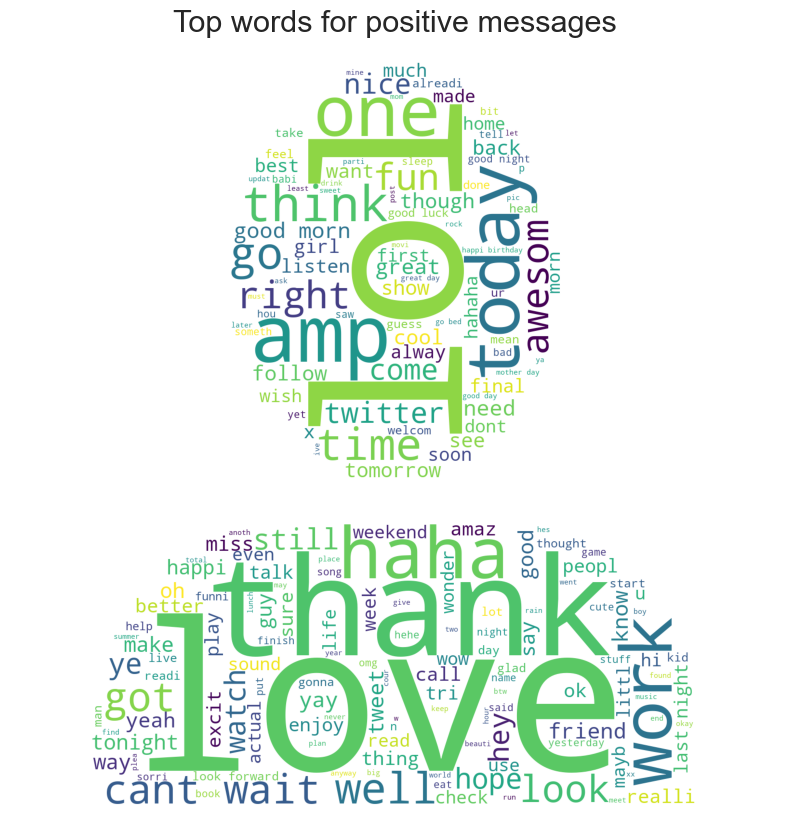

In [59]:
# Wordcloud positive words
twitter_mask = np.array(Image.open('./img/user.jpeg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in emote.loc[emote['emotion'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for positive messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

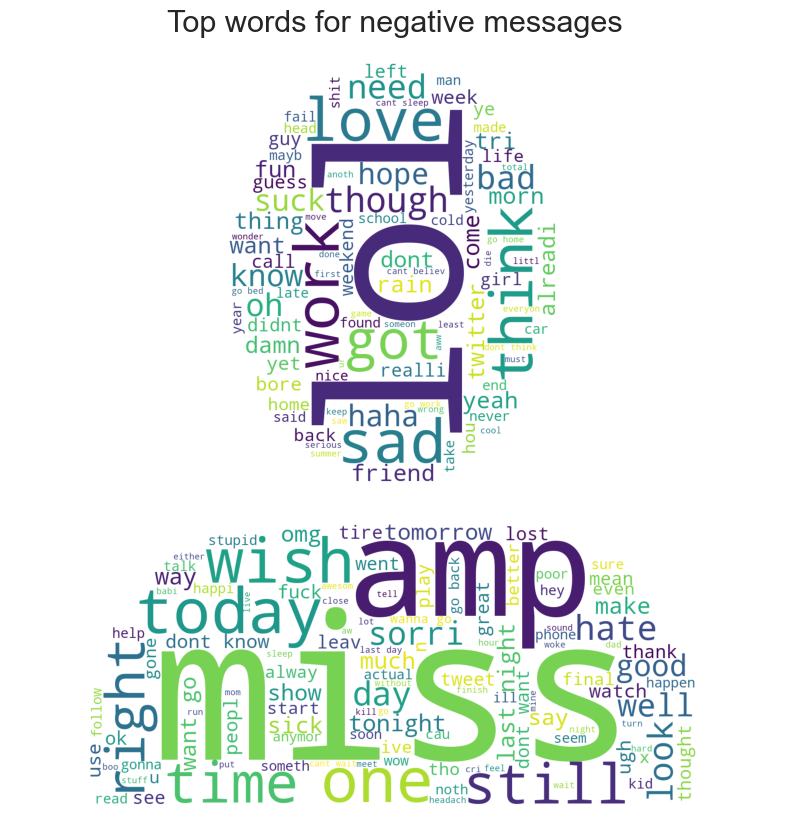

In [60]:
# Wordcloud negative words
twitter_mask = np.array(Image.open('./img/user.jpeg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in emote.loc[emote['emotion'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for negative messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

Now that we have taken a good first look at our data. It is time to build some models. Since we are trying to predict a binary outcome, that is the sentiment of a given tweet, we will proceed with classification algorithms. <br>
First, we need to transform our text data into a numerical structure that can be processed by the algorithms. We do so by using NLP techniques that transform text data into tokens using a vectorizer. These tokens can then be weighted depending on words occurrences and possible importance through a Term-Frequency & Inverse-Document-Frequency (TF-IDF) operation.
We can then apply various classification algorithms on our transformed text data to make prediction on the sentiment of a tweet. <br>
Looking at the 5 most talkative users and their messages polarity, it seems to be a good idea to add usernames as part of the independent variables. Thus our features consist of transformed text with associated usernames.

In [6]:
# Keep only user, text and emotion class
emote = emote[['emotion', 'user', 'text']] 
#emote = emote[['emotion', 'user', 'text', 'text_clean']] # model from the class project
#emote = emote[['emotion', 'user', 'text', 'date']] # should have done this

emote_50 = emote[:50000]   #  50.000 first obs
emote_100 = emote[:100000] # 100.000 first obs
emote_320 = emote[:320000] #  about 1/4 of obs
emote_640 = emote[:640000] #  about 1/2 of obs

### Feature Engineering : TF-IDF and word embeddings

Machine Learning models don't process raw text data. We have to first translate the messages as sequences of numerical tokens. The words are encoded as vectors in a high dimensional space where the similarity in words meaning translates into closeness in the vectorial space.

##### The Vectorization and TF-IDF method

We will extract the numerical features of our text content using a first tool that will vectorize our corpus then a second one that will take into account the frequency of appearance of our words tokens. 

First, we make use of CountVectorizer. This method tokenizes strings of words by transforming them into tokens (using white spaces as token separators) and counts the occurrences of words in our text dataset.

In [62]:
# Data split
X_train, X_test, y_train, y_test = train_test_split((emote_50.text + emote_50.user), emote_50.emotion, test_size=0.1, random_state=37)
print("First 5 entries of training dataset :", X_train.head())

First 5 entries of training dataset : Id
48733    says good morning!  http://plurk.com/p/yyfu1or...
10709    @winebybrad No we had right amount of wine. No...
34219              But hey, free money is free money c0rsa
30883                   Free ice cream and I said no mrl14
36640    @andrewbravener Happy Birthday!  What's better...
dtype: object


In the following section, we will insert these vectorizer and tfidf transformer into the Machine Learning pipeline. It will help us hypertune independently each model.

### CountVectorizer

CountVectorizer is a feature extraction technique in natural language processing (NLP) and text mining. It is a part of the scikit-learn library in Python and is used to convert a collection of text documents to a matrix of token counts. In simpler terms, it transforms a set of text documents into a matrix, where each row represents a document, each column represents a unique word in the corpus, and the entries are the counts of each word in the respective documents.

Here's a basic overview of how CountVectorizer works:

**Tokenization**: It first tokenizes the text, which means it breaks down the text into individual words or terms. This process involves removing punctuation and splitting the text into words.

**Counting**: It then counts the occurrences of each word in the text. The result is a sparse matrix where each row corresponds to a document, each column corresponds to a unique word, and the entries represent the frequency of each word in the respective documents.

**CountVectorizer** is a fundamental step in many text-based machine learning applications, providing a way to represent textual data in a format that machine learning algorithms can understand and process. It's important to note that the resulting matrix can be quite large and sparse, especially when dealing with a large vocabulary or a large number of documents.

In [63]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1)
X_cv_train = count_vectorizer.fit_transform(X_train)
X_cv_test = count_vectorizer.transform(X_test)

### TF-IDF

**TF-IDF** stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents (corpus). TF-IDF is commonly used in information retrieval and text mining as a way to evaluate the importance of a term within a document or a set of documents.

Here's a breakdown of the components:

**Term Frequency (TF)**: This component measures how often a term appears in a document. It is calculated as the ratio of the number of times a term occurs in a document to the total number of terms in that document. The idea is that more frequent terms are likely to be more important within the document.

**TF(t,d)** = Number of times term t appears in document d / Total number of terms in document d

**Inverse Document Frequency (IDF)**: This component measures how important a term is across a collection of documents. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term. Terms that appear in fewer documents are assigned a higher IDF weight, as they are considered more informative.

**IDF(t,D)** = log(Total number of documents in the corpus N / Number of documents containing term t+1)

The addition of 1 in the denominator is known as "smoothing" and helps avoid division by zero when a term is not present in any document.

**TF-IDF Score**: The TF-IDF score for a term in a document is the product of its Term Frequency and Inverse Document Frequency.

**TF-IDF(t,d,D)** = TF(t,d) × IDF(t,D)

The TF-IDF score emphasizes terms that are frequent within a specific document but relatively rare across the entire document collection. This helps in identifying terms that are important and distinctive to a particular document.

TF-IDF is widely used in tasks such as text mining, information retrieval, and document classification. It helps in transforming unstructured text data into a numerical format that can be used for machine learning algorithms.

Now we reweight the words counts through TF-IDF so that they can be used by classifier methods.

In [64]:
tfidftransformer = TfidfTransformer()
X_tf_train = tfidftransformer.fit_transform(X_cv_train)
X_tf_test = tfidftransformer.transform(X_cv_test)

These steps can also be grouped as one unique one through:

In [65]:
tfidf = TfidfVectorizer() # same as CountVectorizer() + TfidfTransformer() combined
X_tf_train = tfidf.fit_transform(X_train)
X_tf_test = tfidf.transform(X_test)

# III. Model Selection

The aim of this project is to build the most accurate classifier that will better predict the sentiment of a tweet. In this aim, I will compare the accuracy scores of the most commonly used classifiers for this NLP task: Logistic Regression, Multinomial Naive Bayes (MNB), Support Vector Machine (SVM), Random Forest (RF), XGBoost and Deep Learning methods (LSTM, GRU, Trasnformers). For each non-DL method, I will hypertune the parameters and get the best pseudo-accuracy (pseudo because I can't try all exisiting combination of hyperparameters, not on this computer at least).

In [5]:
results = pd.DataFrame()
results_log = pd.DataFrame()
results_mnb = pd.DataFrame()
results_svm = pd.DataFrame()
results_rf = pd.DataFrame()
results_xgb = pd.DataFrame()
results_dl = pd.DataFrame()
final_results = pd.DataFrame()

## Logistic Classification

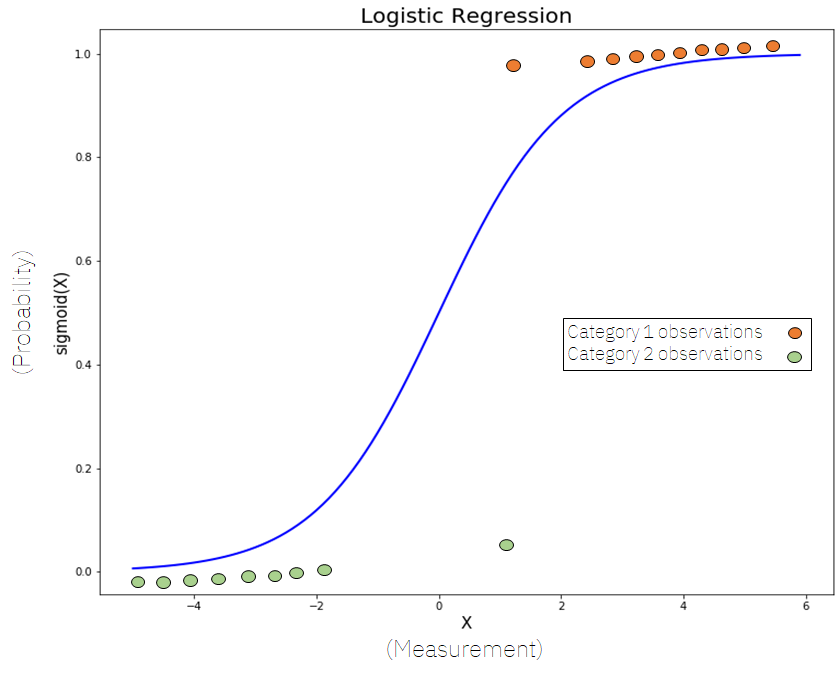


Logistic regression is a statistical method used for binary classification. It is a type of regression analysis that is well-suited for predicting the probability of an outcome that can take on two possible values, typically 0 and 1. The outcome variable in logistic regression is often referred to as the dependent variable, and it represents the categorical response or class that we want to predict.

The logistic regression model uses the logistic function (also known as the sigmoid function) to transform a linear combination of input features into a value between 0 and 1. The logistic function is defined as:


Here: P(Y=1)= 1 / (1+e−(b0+b1x1+b2x2+…+bnxn))

- P(Y=1) is the probability of the dependent variable (Y) being equal to 1.
- e is the base of the natural logarithm.
- b0, b1, b2, …, bn are the coefficients of the model.
- x1, x2, …, xn are the input features.

The logistic regression model estimates the coefficients b0, b1, b2, …, bn based on the training data. Once the model is trained, it can be used to predict the probability of the binary outcome for new, unseen data.

It is a model commonly used in classification task and so it will be the first I apply.

Performing grid search...

Data length:  40000
Pipeline: CountVectorizer() TfidfTransformer() LogisticRegression()

Parameters:
{'model__C': (0.9,),
 'model__penalty': ('l2',),
 'model__solver': ('lbfgs', 'liblinear'),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Duration: 78.5s (n_jobs: 2)

Best score: 0.770
Best parameters set:
	model__C: 0.9
	model__penalty: 'l2'
	model__solver: 'liblinear'
	vect__ngram_range: (1, 2)


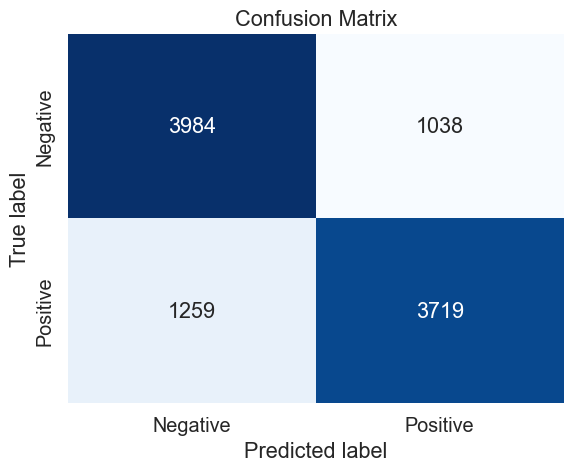

In [67]:
# Define the train and test sets (50 000 observations)
data = emote_50
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_log = {
    # 'vect__max_df': (0.5,),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'model__C': (.9,),
    'model__penalty': ('l2',),
    'model__solver': ('lbfgs', 'liblinear'),
}

# Perform the grid search
gs = GridSearch_(X_train, 
                 y_train, 
                 n_jobs=2,
                 parameters = parameters_log,
                 model = LogisticRegression())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

log_50_cv_results = make_results('log', '50', gs, 'accuracy')
results = pd.concat([results, log_50_cv_results], axis=0)
results_log = pd.concat([results_log, log_50_cv_results], axis=0)

Performing grid search...

Data length:  80000
Pipeline: CountVectorizer() TfidfTransformer() LogisticRegression(max_iter=500)

Parameters:
{'model__C': (0.9, 1.0),
 'model__penalty': ('l2',),
 'model__solver': ('newton-cg', 'lbfgs', 'liblinear'),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Duration: 458.7s (n_jobs: 2)

Best score: 0.785
Best parameters set:
	model__C: 1.0
	model__penalty: 'l2'
	model__solver: 'liblinear'
	vect__ngram_range: (1, 2)


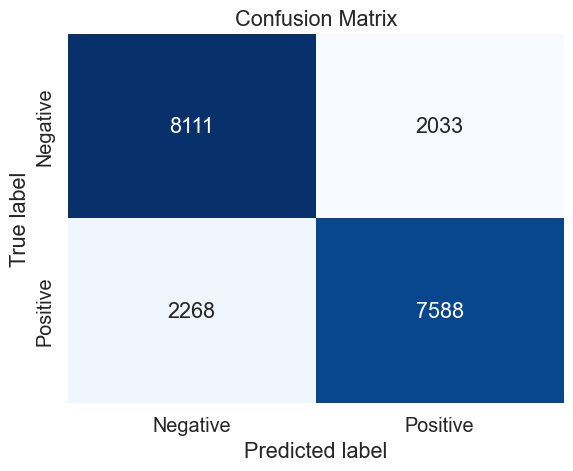

In [68]:
# Define the train and test sets (100 000 observations)
data = emote_100
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user),
                                                    data.emotion,
                                                    test_size=0.2,
                                                    random_state=37)

# Define the parameters to tune
parameters_log = {
    # 'vect__max_df': (0.5,),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'model__C': (.9, 1.0),
    'model__penalty': ('l2', ),
    'model__solver': ('newton-cg', 'lbfgs', 'liblinear'),
}

# Perform the grid search
gs = GridSearch_(X_train,
                 y_train,
                 n_jobs=2,
                 parameters=parameters_log,
                 model=LogisticRegression(max_iter=500))

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat,
    fmt='d',
    cbar=False,
    annot=True,
    #square=True,
    cmap=plt.cm.Blues,
    xticklabels=('Negative', 'Positive'),
    yticklabels=('Negative', 'Positive'))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

log_100_cv_results = make_results('log', '100', gs, 'accuracy')
results = pd.concat([results, log_100_cv_results], axis=0)
results_log = pd.concat([results_log, log_100_cv_results], axis=0)

Performing grid search...

Data length:  256000
Pipeline: CountVectorizer() TfidfTransformer() LogisticRegression(max_iter=500)

Parameters:
{'model__C': (0.9, 1.0),
 'model__penalty': ('l2',),
 'model__solver': ('lbfgs',),
 'vect__max_df': (0.05, 0.1, 0.15),
 'vect__ngram_range': ((1, 2),)}

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Duration: 848.9s (n_jobs: -1)

Best score: 0.803
Best parameters set:
	model__C: 1.0
	model__penalty: 'l2'
	model__solver: 'lbfgs'
	vect__max_df: 0.1
	vect__ngram_range: (1, 2)


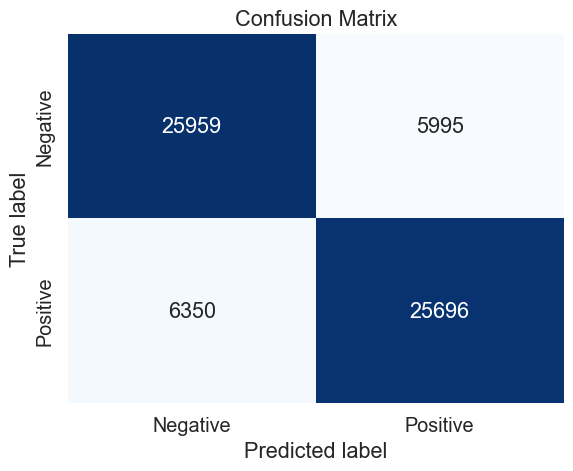

In [69]:
# Define the train and test sets (320 000 observations)
data = emote_320
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_log = {
    'vect__max_df': (.05,.1,0.15,),
    'vect__ngram_range': ((1, 2),),
    'model__C': (.9, 1.0),
    'model__penalty': ('l2',),
    'model__solver': ('lbfgs',),
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = parameters_log, model = LogisticRegression(max_iter=500))

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

log_320_cv_results = make_results('log', '320', gs, 'accuracy')
results = pd.concat([results, log_320_cv_results], axis=0)
results_log = pd.concat([results_log, log_320_cv_results], axis=0)

Performing grid search...

Data length:  1023144
Pipeline: CountVectorizer() TfidfTransformer() LogisticRegression(max_iter=500)

Parameters:
{'model__C': (1.0,),
 'model__penalty': ('l2',),
 'model__solver': ('lbfgs',),
 'vect__max_df': (0.1,),
 'vect__ngram_range': ((1, 2),)}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Duration: 1132.8s (n_jobs: -1)

Best score: 0.821
Best parameters set:
	model__C: 1.0
	model__penalty: 'l2'
	model__solver: 'lbfgs'
	vect__max_df: 0.1
	vect__ngram_range: (1, 2)


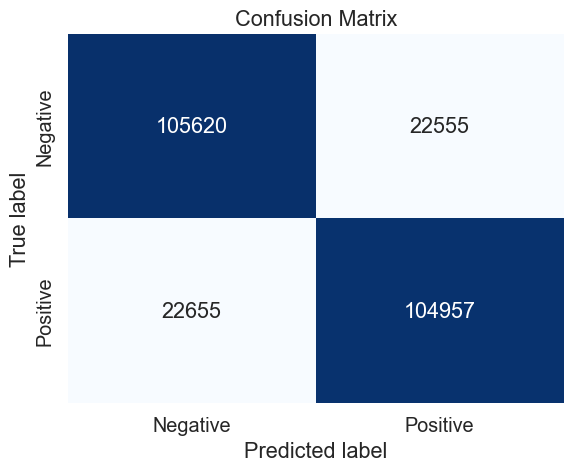

In [70]:
######################################### Final hypertuned model #########################################

# Define the train and test sets (all observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=42)

# Define the parameters to tune
best_parameters_log = {
    'vect__max_df': (.1,),
    'vect__ngram_range': ((1, 2),),
    'model__C': (1.0,),
    'model__penalty': ('l2',),
    'model__solver': ('lbfgs',)
}

# Perform the grid search
#gs = GridSearch_(X_train, y_train, parameters = best_parameters_log, model = LogisticRegression())
gs = GridSearch_(X_train, y_train, parameters = best_parameters_log, model = LogisticRegression(max_iter=500))

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

log_cv_results = make_results('log', 'all', gs, 'accuracy')
results = pd.concat([results, log_cv_results], axis=0)
results_log = pd.concat([results_log, log_cv_results], axis=0)

## Multinomial Naive Bayes (MNB)

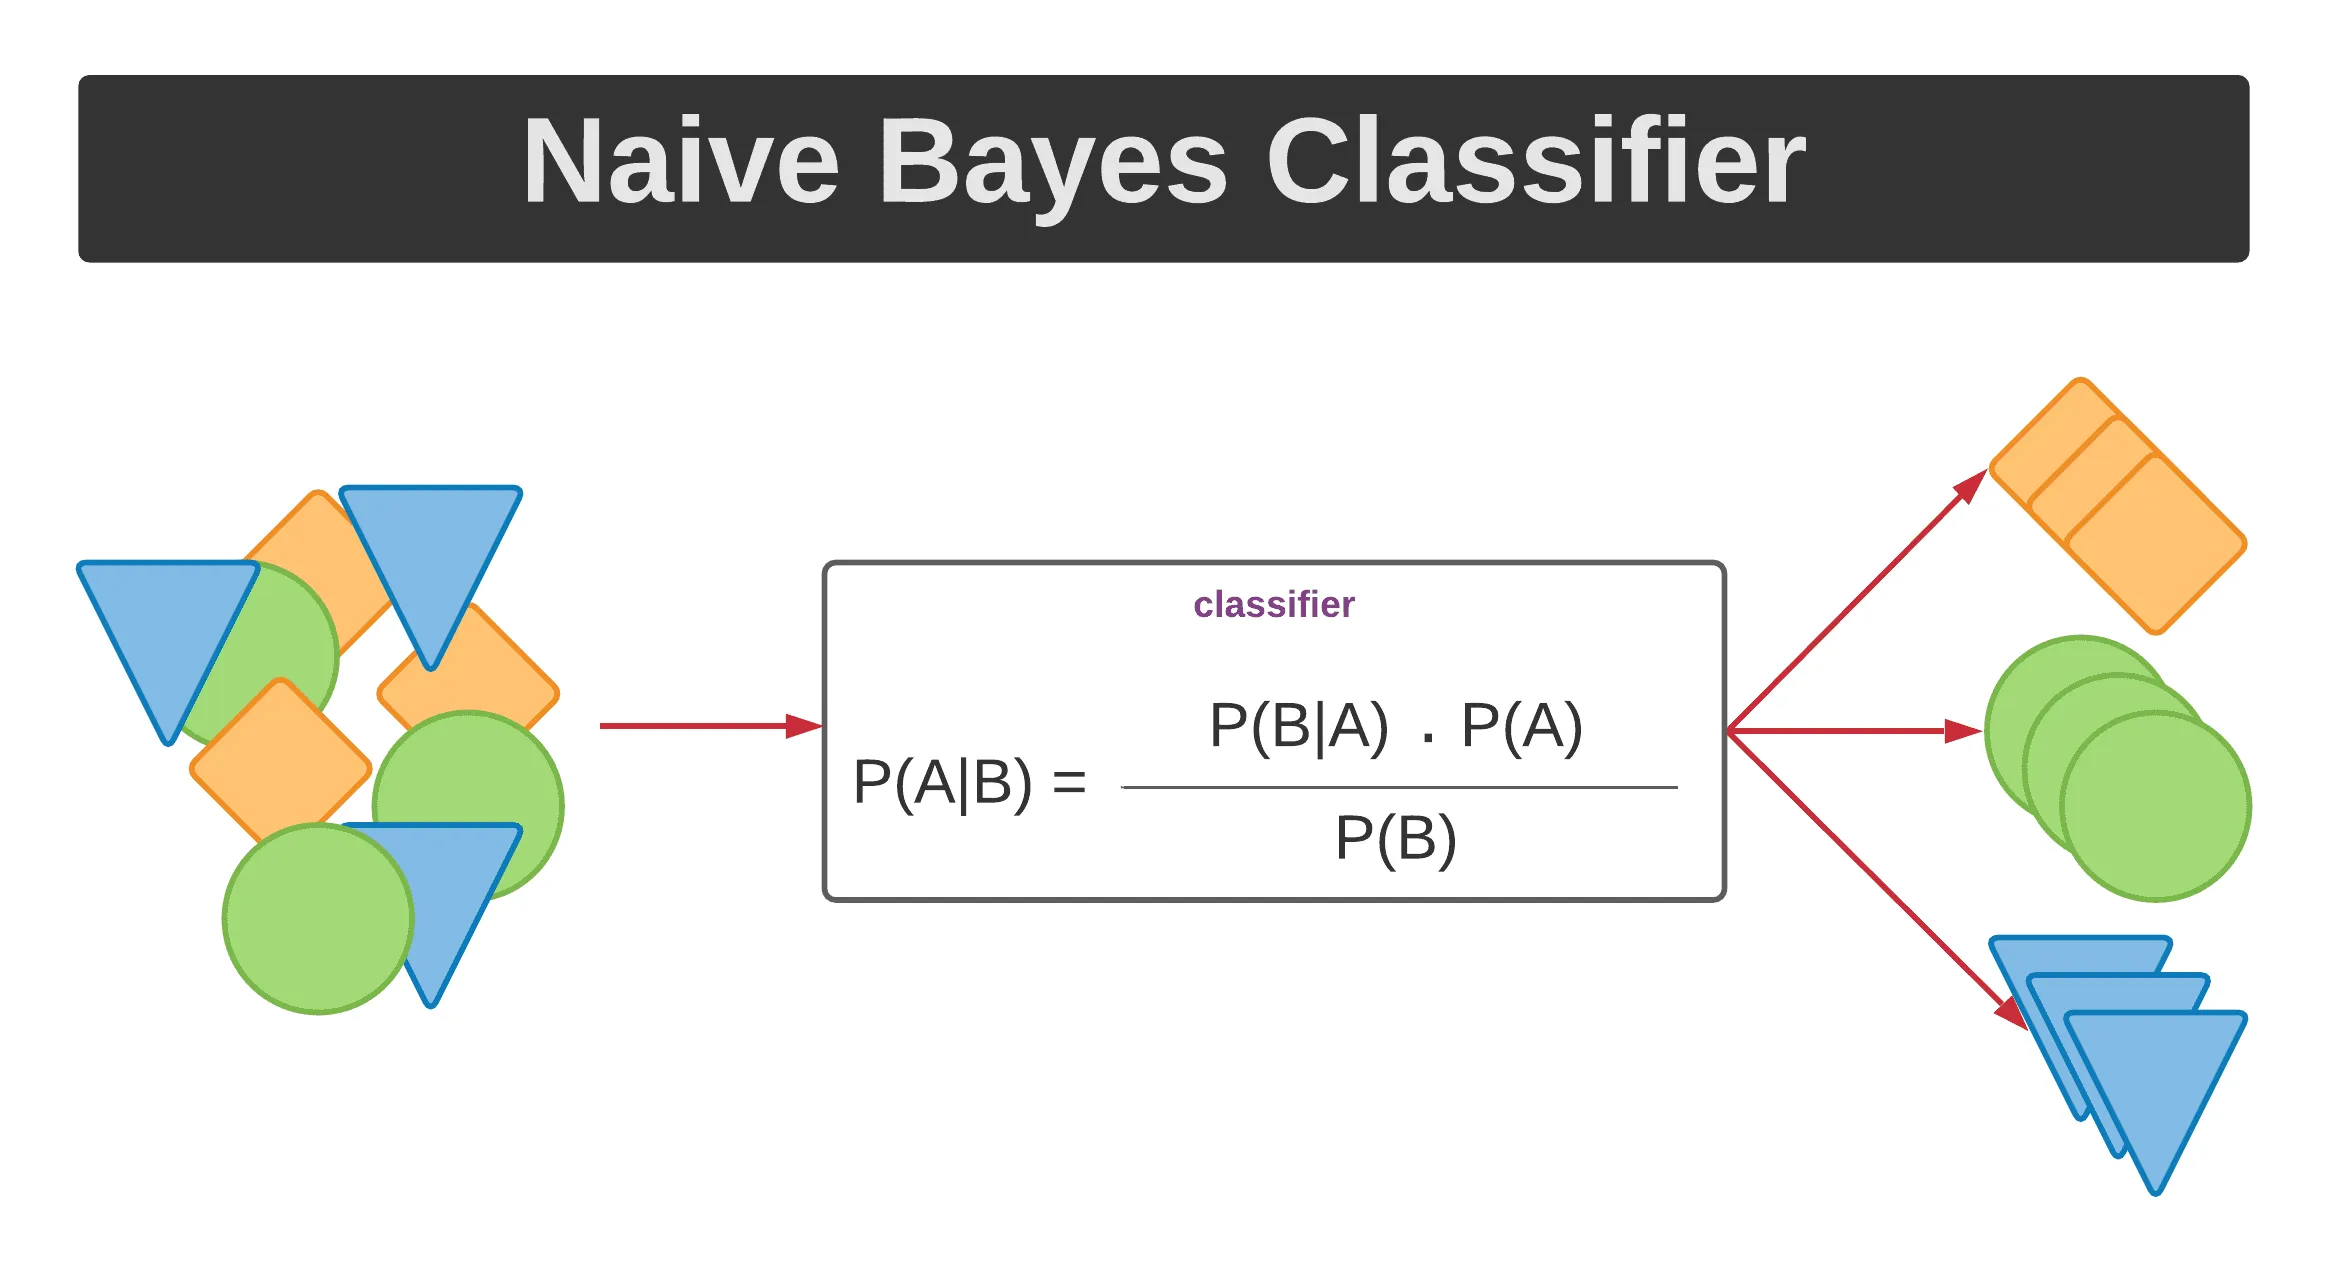

Multinomial Naive Bayes is a probabilistic classification algorithm that is based on Bayes' theorem. It is particularly suitable for classification tasks where the features are discrete and represent the frequency of occurrence of events.

Key Features:

**Discrete Features**: Multinomial Naive Bayes is designed for features that represent counts or frequencies, making it well-suited for text classification problems where each feature could be the frequency of a word in a document.

**Naive Assumption**: Like other Naive Bayes algorithms, it makes the "naive" assumption that the features are conditionally independent given the class label. While this assumption is often violated in real-world data, Naive Bayes models can still perform surprisingly well in practice.

**Probability Model**: It models the likelihood of observing a particular set of features given a class label, and it uses Bayes' theorem to compute the probability of a class given the observed features.

Use Cases:

Multinomial Naive Bayes is commonly used in natural language processing (NLP) tasks such as text classification, spam filtering, and sentiment analysis. It's particularly popular for handling text data due to its simplicity and efficiency.

Formula:

The probability of class Ck given the features x1,x2,...,xn is given by: P(Ck∣x1,x2,...,xn) = P(Ck)×P(x1∣Ck)×P(x2∣Ck)×…×P(xn∣Ck) / P(x1,x2,...,xn)

In practice, the denominator can be ignored since it's constant for all classes, and the class with the highest numerator is chosen as the predicted class.

Multinomial Naive Bayes has proven to be effective in many text classification scenarios, but its performance can be influenced by the quality of the feature representation and the independence assumptions.

Performing grid search...

Data length:  40000
Pipeline: CountVectorizer() TfidfTransformer() MultinomialNB()

Parameters:
{'model__alpha': (0.9, 1),
 'vect__max_df': (0.1, 0.2),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Duration: 82.9s (n_jobs: 2)

Best score: 0.763
Best parameters set:
	model__alpha: 0.9
	vect__max_df: 0.1
	vect__ngram_range: (1, 2)


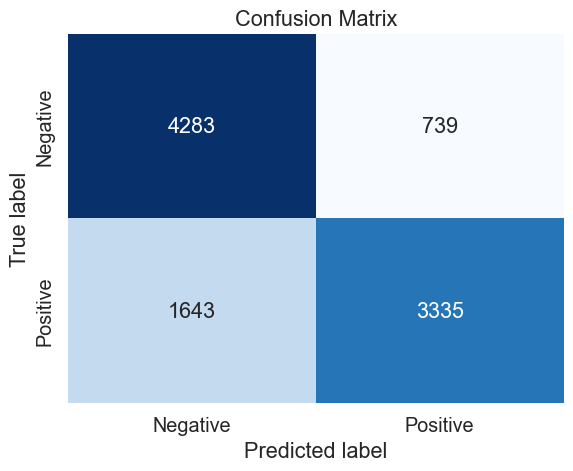

In [71]:
# Define the train and test sets (50 000 observations)
data = emote_50
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_mnb = {
    'vect__max_df': (.1,.2,),
    'vect__ngram_range': ((1, 2), (1, 3)),  
    'model__alpha': (.9,1,),
    #'model__penalty': ('l2','elasticnet'),
}

# Perform the grid search
gs = GridSearch_(X_train, 
                 y_train, 
                 n_jobs=2,
                 parameters = parameters_mnb, 
                 model = MultinomialNB())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

mnb_50_cv_results = make_results('mnb', '50', gs, 'accuracy')
results = pd.concat([results, mnb_50_cv_results], axis=0)
results_mnb = pd.concat([results_mnb, mnb_50_cv_results], axis=0)

Performing grid search...

Data length:  80000
Pipeline: CountVectorizer() TfidfTransformer() MultinomialNB()

Parameters:
{'model__alpha': (0.9, 1),
 'vect__max_df': (0.05, 0.1, 0.15),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Duration: 241.9s (n_jobs: 2)

Best score: 0.778
Best parameters set:
	model__alpha: 0.9
	vect__max_df: 0.1
	vect__ngram_range: (1, 3)


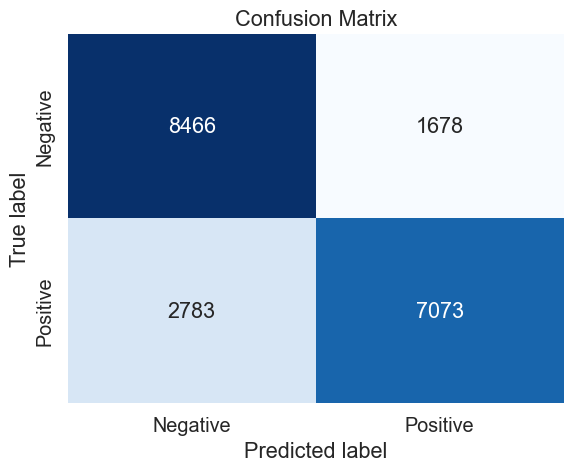

In [72]:
# Define the train and test sets (100 000 observations)
data = emote_100
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_mnb = {
    'vect__max_df': (.05,.1,.15,),
    'vect__ngram_range': ((1, 2), (1, 3)),  
    'model__alpha': (.9, 1,),
    #'model__penalty': ('l2','elasticnet'),
}

# Perform the grid search
gs = GridSearch_(X_train, 
                 y_train, 
                 n_jobs=2,
                 parameters = parameters_mnb, 
                 model = MultinomialNB())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

mnb_100_cv_results = make_results('mnb', '100', gs, 'accuracy')
results = pd.concat([results, mnb_100_cv_results], axis=0)
results_mnb = pd.concat([results_mnb, mnb_100_cv_results], axis=0)

Performing grid search...

Data length:  256000
Pipeline: CountVectorizer() TfidfTransformer() MultinomialNB()

Parameters:
{'model__alpha': (0.8, 0.9, 1),
 'vect__max_df': (0.05, 0.1, 0.15),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Duration: 535.2s (n_jobs: -1)

Best score: 0.792
Best parameters set:
	model__alpha: 0.8
	vect__max_df: 0.05
	vect__ngram_range: (1, 3)


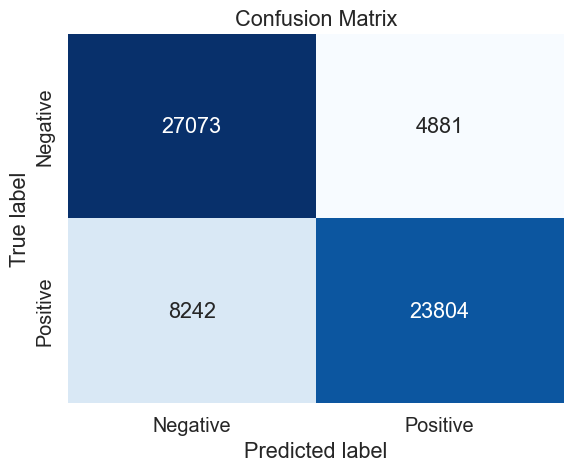

In [73]:
# Define the train and test sets (320 000 observations)
data = emote_320
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_mnb = {
    'vect__max_df': (.05,.1,.15),
    'vect__ngram_range': ((1, 2), (1, 3)),  
    'model__alpha': (.8,.9,1),
    #'model__penalty': ('l2','elasticnet'),
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = parameters_mnb, model = MultinomialNB())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

mnb_320_cv_results = make_results('mnb', '320', gs, 'accuracy')
results = pd.concat([results, mnb_320_cv_results], axis=0)
results_mnb = pd.concat([results_mnb, mnb_320_cv_results], axis=0)

Performing grid search...

Data length:  1023144
Pipeline: CountVectorizer() TfidfTransformer() MultinomialNB()

Parameters:
{'model__alpha': (0.8,),
 'vect__max_df': (0.05,),
 'vect__ngram_range': ((1, 3),)}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Duration: 543.4s (n_jobs: -1)

Best score: 0.810
Best parameters set:
	model__alpha: 0.8
	vect__max_df: 0.05
	vect__ngram_range: (1, 3)


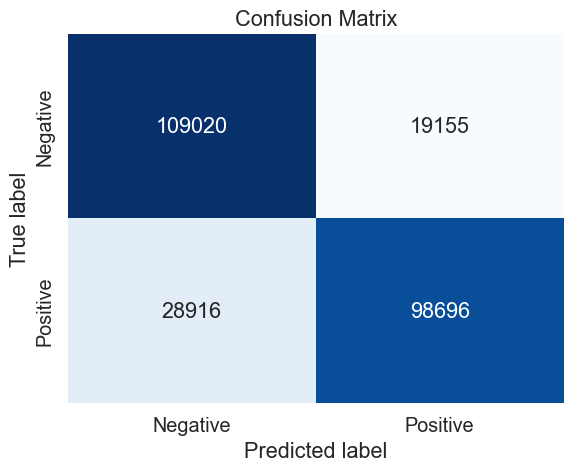

In [74]:
######################################### Final hypertuned model #########################################

# Define the train and test sets (all observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=42)

# Define the parameters to tune
best_parameters_mnb = {
    'vect__max_df': (0.05,),
    'vect__ngram_range': ((1,3),),  
    'model__alpha': (0.8,),
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = best_parameters_mnb, model = MultinomialNB())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

mnb_cv_results = make_results('mnb', 'all', gs, 'accuracy')
results = pd.concat([results, mnb_cv_results], axis=0)
results_mnb = pd.concat([results_mnb, mnb_cv_results], axis=0)

Using only 100 000 observations, we were able here to achieve a score with 77.8% prediction using MNB, a bit less than using logistic regression and even lesser than SVM. These examples were meant to show the difference between each models. We are aware there is some arbitrary choices here in the choice of the parameters for the several Cross-Validation. However, we chose these parameters based on many attempts of finding the best accuracy for each type of model. Overall, SVM performed better than the 2 other shown models here.

## Support Vector Machine (SVM)

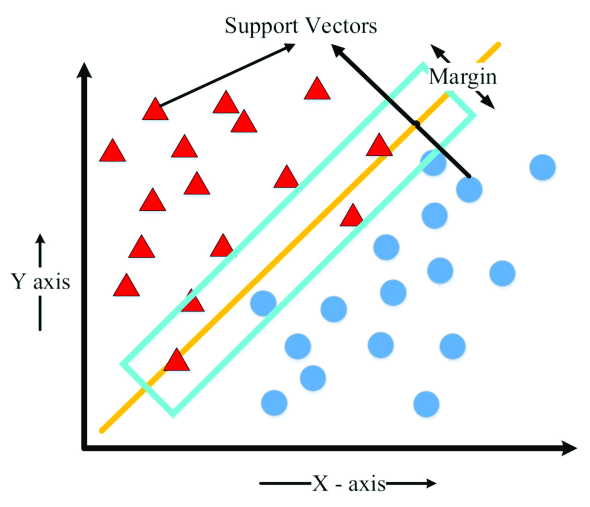

Support Vector Machines (SVM) are a type of supervised machine learning algorithm used for classification and regression tasks. They are particularly effective in high-dimensional spaces and are well-suited for tasks where the data points are not easily separable.

The basic idea behind SVM is to find a hyperplane that best separates the data into different classes. A hyperplane is a decision boundary that divides the input space into regions associated with different classes. The goal is to maximize the margin, which is the distance between the hyperplane and the nearest data points from each class. SVM aims to find the hyperplane that not only separates the data but also maximizes this margin.

In the case of a binary classification problem (dividing data into two classes), the hyperplane can be represented as w⋅x+b=0, where w is the weight vector, x is the input vector, and b is the bias. The sign of w⋅x+b determines the class to which the data point belongs.

SVMs can handle both linear and non-linear classification tasks. For non-linear problems, SVMs use a technique called the "kernel trick" to map the input data into a higher-dimensional space where a hyperplane can be used to separate the classes.

Performing grid search...

Data length:  40000
Pipeline: CountVectorizer() TfidfTransformer() LinearSVC()

Parameters:
{'model__C': (0.7, 0.8, 0.9),
 'model__penalty': ('l2',),
 'vect__max_features': (None, 400000),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Duration: 66.6s (n_jobs: -1)

Best score: 0.780
Best parameters set:
	model__C: 0.8
	model__penalty: 'l2'
	vect__max_features: None
	vect__ngram_range: (1, 2)


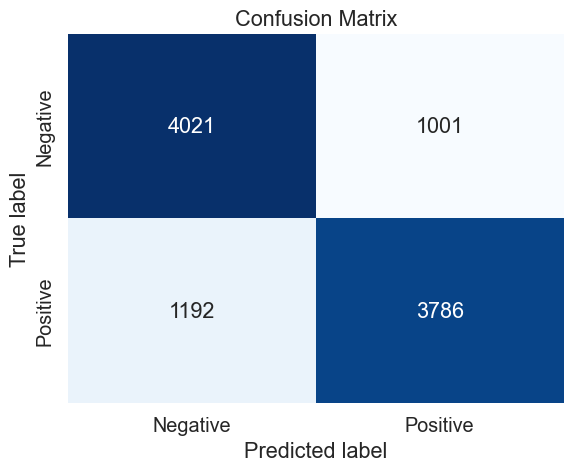

In [75]:
# Define the train and test sets (50 000 observations)
data = emote_50
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_svm = {
    # 'vect__max_df': (0.4, 0.5),
    'vect__max_features': (None, 400000),
    'vect__ngram_range': ((1,2),(1,3),),
    'model__penalty': ('l2',),
    #'model__loss': ('squared_hinge',),
    'model__C': (0.7,0.8,0.9),
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = parameters_svm, model = LinearSVC())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

# Save results
svm_50_cv_results = make_results('svm', '50', gs, 'accuracy')
results = pd.concat([results, svm_50_cv_results], axis=0)
results_svm = pd.concat([results_svm, svm_50_cv_results], axis=0)

Performing grid search...

Data length:  80000
Pipeline: CountVectorizer() TfidfTransformer() LinearSVC()

Parameters:
{'model__C': (0.9, 0.95, 1),
 'model__loss': ('squared_hinge', 'hinge'),
 'model__penalty': ('l2',),
 'vect__max_df': (0.1, 0.15, 0.2),
 'vect__max_features': (None,),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Duration: 626.2s (n_jobs: -1)

Best score: 0.794
Best parameters set:
	model__C: 0.95
	model__loss: 'hinge'
	model__penalty: 'l2'
	vect__max_df: 0.2
	vect__max_features: None
	vect__ngram_range: (1, 2)


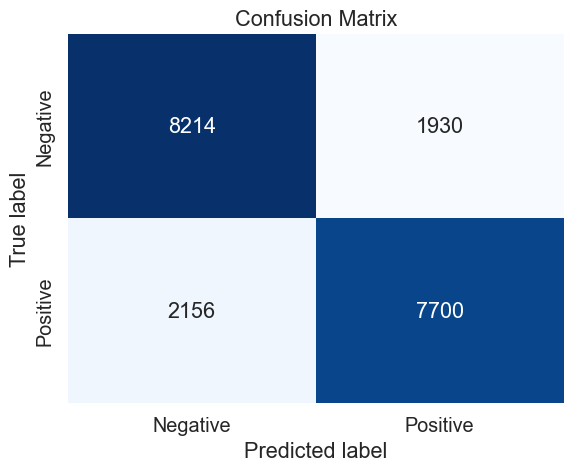

In [76]:
# Define the train and test sets (100 000 observations)
data = emote_100
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_svm = {
    'vect__max_df': (0.1, 0.15, 0.2,),
    'vect__max_features': (None,),
    'vect__ngram_range': ((1,2),(1,3),),
    'model__penalty': ('l2',),
    'model__loss': ('squared_hinge','hinge'),
    'model__C': (0.9, 0.95, 1),
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = parameters_svm, model = LinearSVC())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

# Save results
svm_100_cv_results = make_results('svm', '100', gs, 'accuracy')
results = pd.concat([results, svm_100_cv_results], axis=0)
results_svm = pd.concat([results_svm, svm_100_cv_results], axis=0)

Performing grid search...

Data length:  256000
Pipeline: CountVectorizer() TfidfTransformer() LinearSVC()

Parameters:
{'model__C': (0.8, 0.9, 0.95),
 'model__loss': ('squared_hinge', 'hinge'),
 'model__penalty': ('l2',),
 'vect__max_df': (0.15, 0.2, 0.25),
 'vect__max_features': (None,),
 'vect__ngram_range': ((1, 2), (1, 3))}

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Duration: 1936.4s (n_jobs: -1)

Best score: 0.811
Best parameters set:
	model__C: 0.9
	model__loss: 'squared_hinge'
	model__penalty: 'l2'
	vect__max_df: 0.2
	vect__max_features: None
	vect__ngram_range: (1, 3)


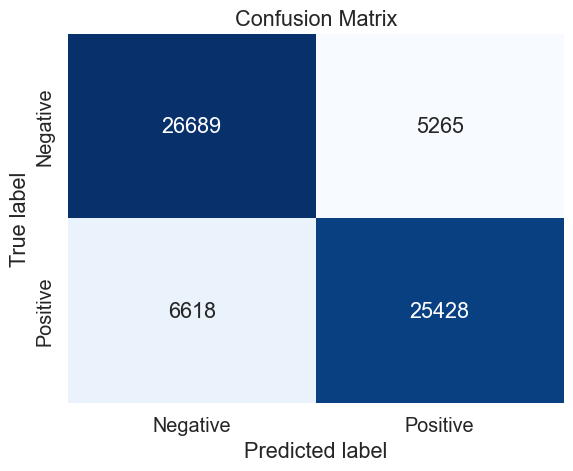

In [77]:
# Define the train and test sets (320 000 observations)
data = emote_320
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_svm = {
    'vect__max_df': (0.15, 0.2, 0.25),
    'vect__max_features': (None,),
    'vect__ngram_range': ((1,2),(1,3),),
    'model__penalty': ('l2',),
    'model__loss': ('squared_hinge','hinge'),
    'model__C': (0.8, 0.9, 0.95),
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = parameters_svm, model = LinearSVC())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

svm_320_cv_results = make_results('svm', '320', gs, 'accuracy')
results = pd.concat([results, svm_320_cv_results], axis=0)
results_svm = pd.concat([results_svm, svm_320_cv_results], axis=0)

Performing grid search...

Data length:  1023144
Pipeline: CountVectorizer() TfidfTransformer() LinearSVC()

Parameters:
{'model__C': (0.9,),
 'model__loss': ('hinge',),
 'model__penalty': ('l2',),
 'vect__max_df': (0.2,),
 'vect__max_features': (None,),
 'vect__ngram_range': ((1, 2),)}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\rened\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Duration: 505.1s (n_jobs: -1)

Best score: 0.828
Best parameters set:
	model__C: 0.9
	model__loss: 'hinge'
	model__penalty: 'l2'
	vect__max_df: 0.2
	vect__max_features: None
	vect__ngram_range: (1, 2)


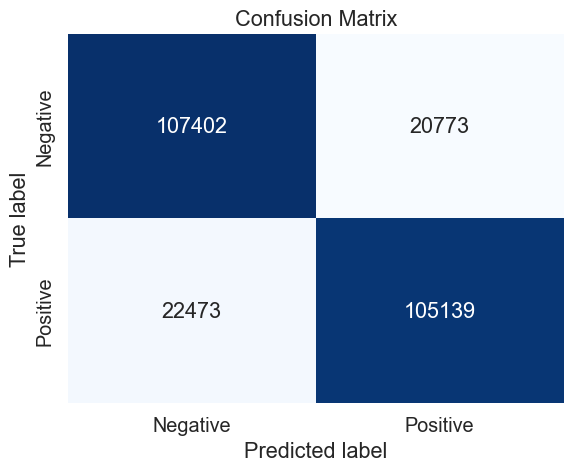

In [78]:
######################################### Final hypertuned model #########################################

# Define the train and test sets (all observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=42)

# Define the parameters to tune
best_parameters_svm = {
    'vect__max_df': (0.2,),
    'vect__max_features': (None,),
    'vect__ngram_range': ((1,2),),
    'model__penalty': ('l2',),
    'model__loss': ('hinge',),
    'model__C': (0.9,),
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = best_parameters_svm, model = LinearSVC())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

svm_cv_results = make_results('svm', 'all', gs, 'accuracy')
results = pd.concat([results, svm_cv_results], axis=0)
results_svm = pd.concat([results_svm, svm_cv_results], axis=0)

## Random Forest

Random Forest is a machine learning algorithm that is commonly used for both classification and regression tasks. It is an ensemble learning method, meaning it builds multiple decision trees during training and merges them together to get a more accurate and stable prediction.

Here's how Random Forest works for classification:

- **Bootstrapping (Random Sampling with Replacement)**: The algorithm starts by creating multiple random subsets of the training data through a process called bootstrapping. Each subset is used to train a decision tree.

- **Decision Tree Construction**: For each subset of data, a decision tree is constructed. Decision trees are built by recursively splitting the data based on features, aiming to maximize the information gain or decrease in impurity at each node.

- **Voting**: Once all the decision trees are trained, they make predictions on new data. For classification tasks, each tree "votes" for a class, and the class with the majority of votes becomes the predicted class for the Random Forest.

- **Aggregation**: The final prediction is determined by aggregating the individual predictions from all the trees. For classification, this often involves selecting the class with the highest number of votes.

The key idea behind Random Forest is that by combining multiple decision trees trained on different subsets of data, the model tends to be more robust and less prone to overfitting compared to individual decision trees. Additionally, Random Forest can handle a large number of features, provides a measure of feature importance, and is relatively easy to use with minimal hyperparameter tuning.

The "random" in Random Forest comes from two sources of randomness: random sampling of data points (bootstrapping) and random subsets of features considered at each split in the decision tree construction process. This helps to decorrelate the individual trees and create a diverse set of models, leading to a more accurate and robust ensemble.

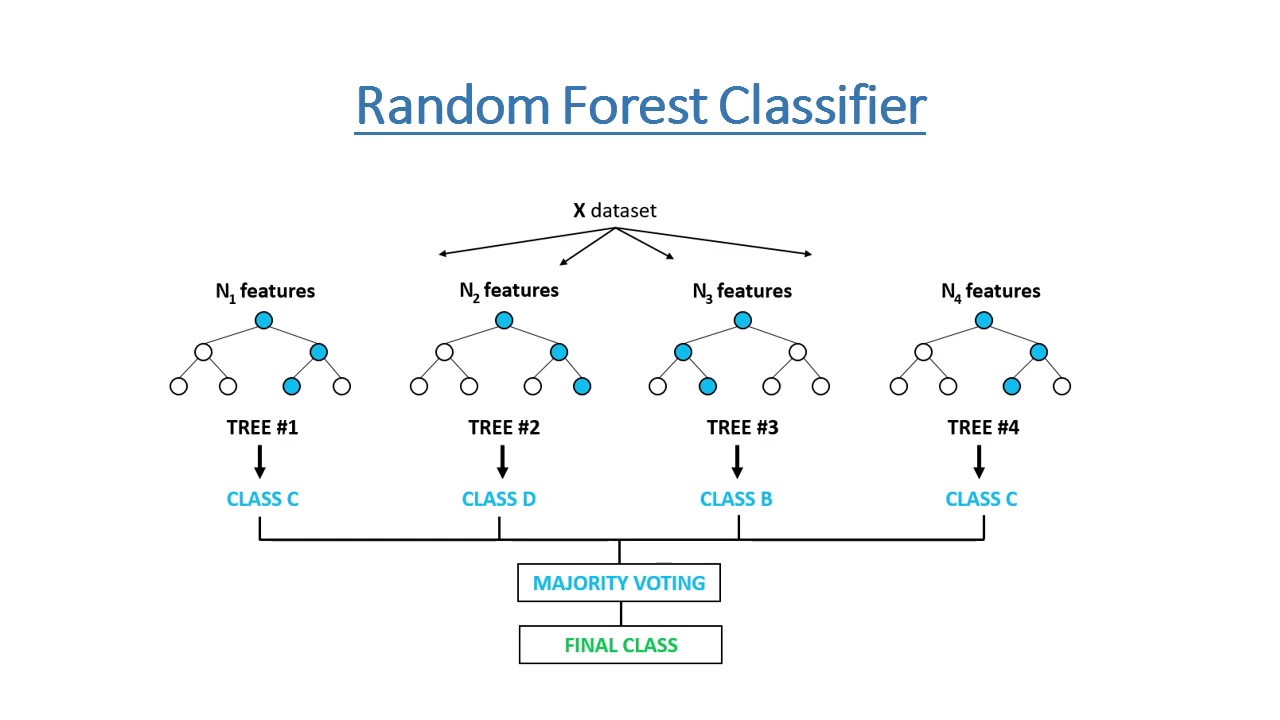

In [79]:
'''# Define the train and test sets (50 000 observations)
data = emote_50
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune
parameters_rf = {
    # 'vect__max_df': (0.4, 0.5),
    #'vect__max_features': (None, 200000, 400000),
    #'vect__ngram_range': ((1,2),(1,3),),
    'model__max_features': ('sqrt','log2'),       # default: sqrt 
    'model__n_estimators': (100, 500,),                  # default: 100
    'model__criterion': ('gini', 'entropy', 'log_loss'),   # default: gini
    'model__max_depth': ('None', 1000,),             # default: None
    'model__min_samples_leaf': (1, 5, 10)            # default: 1
}

# Perform the grid search
gs = GridSearch_(X_train, 
                 y_train, 
                 parameters = parameters_rf, 
                 model = RandomForestClassifier())

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

# Save results
rf_50_cv_results = make_results('rf', '50', gs, 'accuracy')
results = pd.concat([results, rf_50_cv_results], axis=0)
results_rf = pd.concat([results_rf, rf_50_cv_results], axis=0)'''

"# Define the train and test sets (50 000 observations)\ndata = emote_50\nX_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)\n\n# Define the parameters to tune\nparameters_rf = {\n    # 'vect__max_df': (0.4, 0.5),\n    #'vect__max_features': (None, 200000, 400000),\n    #'vect__ngram_range': ((1,2),(1,3),),\n    'model__max_features': ('sqrt','log2'),       # default: sqrt \n    'model__n_estimators': (100, 500,),                  # default: 100\n    'model__criterion': ('gini', 'entropy', 'log_loss'),   # default: gini\n    'model__max_depth': ('None', 1000,),             # default: None\n    'model__min_samples_leaf': (1, 5, 10)            # default: 1\n}\n\n# Perform the grid search\ngs = GridSearch_(X_train, \n                 y_train, \n                 parameters = parameters_rf, \n                 model = RandomForestClassifier())\n\n# Prediction with best parameters\ny_pred = gs.predict(X_test)\n\n# Confusi

## XGBoost

XGBoost, which stands for eXtreme Gradient Boosting, is a popular and powerful machine learning algorithm used for regression and classification tasks. It belongs to the family of gradient boosting algorithms, which are ensemble learning methods. Ensemble learning involves combining the predictions of multiple machine learning models to improve overall performance.

Here are the parameters we can tune: https://xgboost.readthedocs.io/en/stable/parameter.html

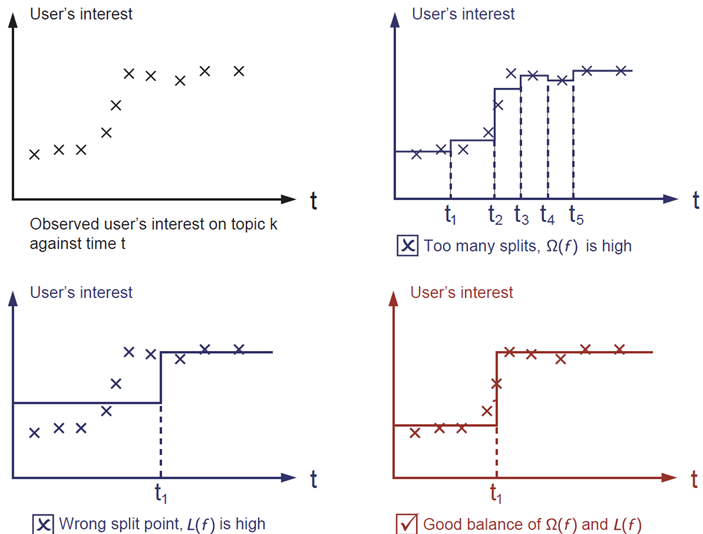

Performing grid search...

Data length:  40000
Pipeline: CountVectorizer() TfidfTransformer() XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Parameters:
{'model__learning_rate': [0.1, 0.2, 0.4, 0.5, 0.8],
 'model__max_depth': [3, 5, 10],
 'model__min_child_weight': [0.5, 1, 2, 5],
 'mod

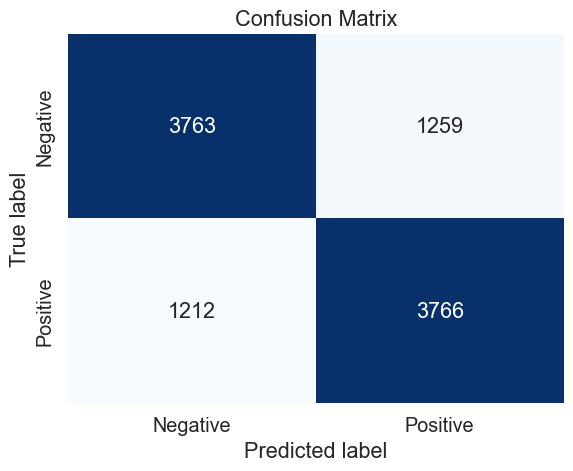

In [80]:
# Define the train and test sets (50 000 observations)
data = emote_50
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune 
# Common values: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
parameters_xgb = {'model__max_depth' : [3,5,10], # maximum depth of a tree, same as GBM.
                  'model__learning_rate': [.1,.2,.4,.5,.8], # the step size shrinkage used in update to prevent overfitting.
                  'model__n_estimators': [10,30,50,100],
                  'model__min_child_weight': [.5,1,2,5] # defines the minimum sum of weights of all observations required in a child
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = parameters_xgb, model = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'auc'))

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

xgb_50_cv_results = make_results('xgb', '50', gs, 'accuracy')
results = pd.concat([results, xgb_50_cv_results], axis=0)
results_xgb = pd.concat([results_xgb, xgb_50_cv_results], axis=0)

Performing grid search...

Data length:  80000
Pipeline: CountVectorizer() TfidfTransformer() XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Parameters:
{'model__learning_rate': [0.2, 0.3, 0.4],
 'model__max_depth': [15, 20],
 'model__min_child_weight': [2, 3],
 'model__n_estimators': [

C:\Users\rened\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rened\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rened\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\rened\Anaconda3\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\rened\Anaconda3\lib\site-p

Duration: 33816.8s (n_jobs: 3)

Best score: 0.766
Best parameters set:
	model__learning_rate: 0.3
	model__max_depth: 15
	model__min_child_weight: 2
	model__n_estimators: 200


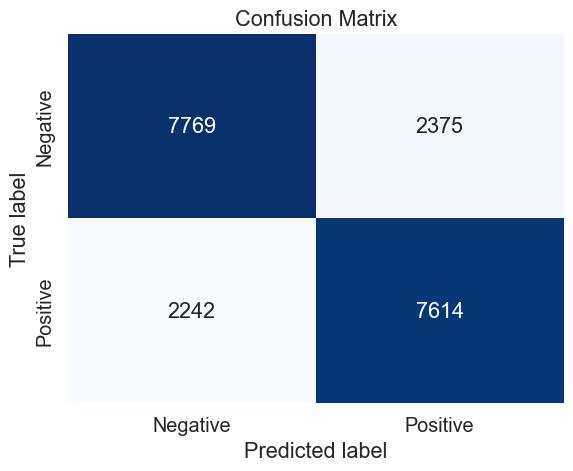

In [81]:
# Define the train and test sets (100 000 observations)
data = emote_100
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune 
# Common values: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
parameters_xgb = {'model__max_depth' : [15,20,], # maximum depth of a tree, same as GBM.
                  'model__learning_rate': [.2,.3,.4,], # the step size shrinkage used in update to prevent overfitting.
                  'model__n_estimators': [150,200,], # number of trees
                  'model__min_child_weight': [2,3,] # defines the minimum sum of weights of all observations required in a child
}

# Perform the grid search
gs = GridSearch_(X_train, 
                 y_train, 
                 n_jobs=3, ############################################################################################## 
                 parameters = parameters_xgb, 
                 model = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'auc'))

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

xgb_100_cv_results = make_results('xgb', '100', gs, 'accuracy')
results = pd.concat([results, xgb_100_cv_results], axis=0)
results_xgb = pd.concat([results_xgb, xgb_100_cv_results], axis=0)

In [84]:
# Define the train and test sets (320 000 observations)
data = emote_320
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

# Define the parameters to tune 
# Common values: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
parameters_xgb = {'model__max_depth' : [15,], # maximum depth of a tree, same as GBM.
                  'model__learning_rate': [.3,], # the step size shrinkage used in update to prevent overfitting.
                  'model__n_estimators': [200,], # number of trees
                  'model__min_child_weight': [2,] # defines the minimum sum of weights of all observations required in a child
}

# Perform the grid search
gs = GridSearch_(X_train, 
                 y_train, 
                 n_jobs=3, ############################################################################################## 
                 parameters = parameters_xgb, 
                 model = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'auc'))

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

xgb_320_cv_results = make_results('xgb', '320', gs, 'accuracy')
results = pd.concat([results, xgb_320_cv_results], axis=0)
results_xgb = pd.concat([results_xgb, xgb_320_cv_results], axis=0)

Performing grid search...

Data length:  256000
Pipeline: CountVectorizer() TfidfTransformer() XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Parameters:
{'model__learning_rate': [0.3],
 'model__max_depth': [15],
 'model__min_child_weight': [2],
 'model__n_estimators': [200]}

Fitting 5

C:\Users\rened\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rened\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rened\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\rened\Anaconda3\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\rened\Anaconda3\lib\site-pack

XGBoostError: [14:32:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\io.h:232: bad_malloc: Failed to allocate 9110324880 bytes.

In [ ]:
######################################### Final hypertuned model #########################################

# Define the train and test sets (all observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=42)

# Define the parameters to tune
parameters_xgb = {'model__max_depth' : [15,], # maximum depth of a tree, same as GBM.
                  'model__learning_rate': [.2,], # the step size shrinkage used in update to prevent overfitting.
                  'model__n_estimators': [200,], # number of trees
                  'model__min_child_weight': [3,] # defines the minimum sum of weights of all observations required in a child
}

# Perform the grid search
gs = GridSearch_(X_train, y_train, parameters = best_parameters_xgb, model = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'auc'))

# Prediction with best parameters
y_pred = gs.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat,
            fmt='d', 
            cbar=False,
            annot=True, 
            #square=True, 
            cmap=plt.cm.Blues,
            xticklabels=('Negative','Positive'),
            yticklabels=('Negative','Positive')
           )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

xgb_cv_results = make_results('xgb', 'all', gs, 'accuracy')
results = pd.concat([results, xgb_cv_results], axis=0)
results_xgb = pd.concat([results_xgb, xgb_cv_results], axis=0)

## Deep Learning

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that is particularly well-suited for sequential data and tasks where capturing long-range dependencies is important

Recurrent neural networks like LSTM generally have the problem of overfitting.
Dropout can be applied between layers using the Dropout Keras layer. We can do this easily by adding new Dropout layers between the Embedding and LSTM layers and the LSTM and Dense output layers. For example:

In [85]:
# Define the train and test sets (320 000 observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

max_features = 50000
nb_classes = 2
maxlen = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)
Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [86]:
batch_size = 128

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train, 
          Y_train, 
          batch_size=batch_size, 
          epochs=2,
          validation_data=(X_test, Y_test))

score, acc = model.evaluate(X_test, 
                            Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Predict the output class
y_pred = model.predict(X_test)

# Extract the most probable class
y_pred = np.argmax(y_pred,axis=1)

# Append results
LSTM_results = make_results_dl('LSTM_1', y_test, y_pred)
results = pd.concat([results, LSTM_results], axis=0)
results_dl = pd.concat([results_dl, LSTM_results], axis=0)

Epoch 1/2
7994/7994 [==============================] - 2045s 255ms/step - loss: 0.4125 - accuracy: 0.8109 - val_loss: 0.3820 - val_accuracy: 0.8281
Epoch 2/2
1999/1999 [==============================] - 105s 50ms/step - loss: 0.3751 - accuracy: 0.8335
Test score: 0.37511518597602844
Test accuracy: 0.8334903717041016
7994/7994 [==============================] - 180s 22ms/step


We can see dropout having the desired impact on training with a slightly slower trend in convergence and, in this case, a lower final accuracy. The model could probably use a few more epochs of training and may achieve a higher skill.

Alternately, dropout can be applied to the input and recurrent connections of the memory units with the LSTM precisely and separately.

Keras provides this capability with parameters on the LSTM layer, the dropout for configuring the input dropout, and recurrent_dropout for configuring the recurrent dropout. For example, we can modify the first example to add dropout to the input and recurrent connections as follows:

In [87]:
# Define the train and test sets (320 000 observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

max_features = 50000
nb_classes = 2
maxlen = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)
Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [88]:
batch_size = 128

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(nb_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train, 
          Y_train, 
          batch_size=batch_size, 
          epochs=2,
          validation_data=(X_test, Y_test))

score, acc = model.evaluate(X_test, 
                            Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Predict the output class
y_pred = model.predict(X_test)

# Extract the most probable class
y_pred = np.argmax(y_pred,axis=1)

# Append results
LSTM_results = make_results_dl('LSTM_2', y_test, y_pred)
results_dl = pd.concat([results_dl, LSTM_results], axis=0)
final_results = pd.concat([final_results, LSTM_results], axis=0)

Epoch 1/2
7994/7994 [==============================] - 3433s 429ms/step - loss: 0.4114 - accuracy: 0.8113 - val_loss: 0.3816 - val_accuracy: 0.8278
Epoch 2/2
1999/1999 [==============================] - 116s 55ms/step - loss: 0.3759 - accuracy: 0.8330
Test score: 0.3758881986141205
Test accuracy: 0.833044707775116
7994/7994 [==============================] - 162s 19ms/step


We can see that the LSTM-specific dropout has a more pronounced effect on the convergence of the network than the layer-wise dropout. Like above, the number of epochs was kept constant and could be increased to see if the skill of the model could be further lifted.

Dropout is a powerful technique for combating overfitting in our LSTM models, and it is a good idea to try both methods. Still, we may get better results with the gate-specific dropout provided in Keras.

In [89]:
# Define the train and test sets (320 000 observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

max_features = 50000
nb_classes = 2
maxlen = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)
Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [90]:
batch_size = 128

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2)) 
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, 
          Y_train, 
          batch_size=batch_size, 
          epochs=2,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, 
                            Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Predict the output class
y_pred = model.predict(X_test)

# Extract the most probable class
y_pred = np.argmax(y_pred,axis=1)

# Append results
LSTM_results = make_results_dl('LSTM_3', y_test, y_pred)
results_dl = pd.concat([results_dl, LSTM_results], axis=0)
final_results = pd.concat([final_results, LSTM_results], axis=0)

Epoch 1/2
7994/7994 [==============================] - 2410s 300ms/step - loss: 0.4112 - accuracy: 0.8112 - val_loss: 0.3821 - val_accuracy: 0.8286
Epoch 2/2
1999/1999 [==============================] - 145s 70ms/step - loss: 0.3728 - accuracy: 0.8331
Test score: 0.3727535009384155
Test accuracy: 0.8330681324005127
7994/7994 [==============================] - 239s 29ms/step


#### LSTM and Convolutional Neural Network

Convolutional neural networks excel at learning the spatial structure in input data.

The twitter data does have a one-dimensional spatial structure in the sequence of words in tweets, and the CNN may be able to pick out invariant features for the good and bad sentiment. This learned spatial feature may then be learned as sequences by an LSTM layer.

We can easily add a one-dimensional CNN and max pooling layers after the Embedding layer, which then feeds the consolidated features to the LSTM. We can use a smallish set of 32 features with a small filter length of 3. The pooling layer can use the standard length of 2 to halve the feature map size.

In [91]:
# Define the train and test sets (320 000 observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

max_features = 50000
nb_classes = 2
maxlen = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)
Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [92]:
batch_size = 32
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, epochs=2,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Predict the output class
y_pred = model.predict(X_test)

# Extract the most probable class
y_pred = np.argmax(y_pred,axis=1)

# Append results
LSTM_results = make_results_dl('LSTM_4', y_test, y_pred)
results = pd.concat([results, LSTM_results], axis=0)
results_dl = pd.concat([results_dl, LSTM_results], axis=0)

Epoch 1/2
31974/31974 [==============================] - 3723s 116ms/step - loss: 0.4037 - accuracy: 0.8160 - val_loss: 0.3774 - val_accuracy: 0.8306
Epoch 2/2
7994/7994 [==============================] - 118s 14ms/step - loss: 0.3727 - accuracy: 0.8334
Test score: 0.3726580739021301
Test accuracy: 0.8334356546401978
7994/7994 [==============================] - 116s 14ms/step


#### Bidirectional LSTM

Sometimes, a sequence is better used in reversed order. In those cases, we can simply reverse a vector x using the Python syntax x[::-1] before using it to train your LSTM network.

Sometimes, neither the forward nor the reversed order works perfectly, but combining them will give better results. In this case, we will need a bidirectional LSTM network.

A bidirectional LSTM network is simply two separate LSTM networks; one feeds with a forward sequence and another with reversed sequence. Then the output of the two LSTM networks is concatenated together before being fed to the subsequent layers of the network. In Keras, there is the function Bidirectional() to clone an LSTM layer for forward-backward input and concatenate their output.

Since we created not one, but two LSTMs with 100 units each, this network will take twice the amount of time to train. Depending on the problem, this additional cost may be justified.

This 80.92% prediction score reflects the accuracy taking 320 000 observations into fitting. Another one using the whole dataset went to 83% on kaggle.

In [93]:
# Define the train and test sets (320 000 observations)
data = emote
X_train, X_test, y_train, y_test = train_test_split((data.text + data.user), data.emotion, test_size=0.2, random_state=37)

max_features = 50000
nb_classes = 2
maxlen = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)
Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [ ]:
batch_size = 128

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(nb_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, 
          Y_train, 
          batch_size=batch_size, 
          epochs=2,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, 
                            Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Predict the output class
y_pred = model.predict(X_test)

# Extract the most probable class
y_pred = np.argmax(y_pred,axis=1)

# Append results
LSTM_results = make_results_dl('LSTM_5', y_test, y_pred)
results = pd.concat([results, LSTM_results], axis=0)
results_dl = pd.concat([results_dl, LSTM_results], axis=0)

Epoch 1/2
7994/7994 [==============================] - 15050s 2s/step - loss: 0.4116 - accuracy: 0.8106 - val_loss: 0.3820 - val_accuracy: 0.8282
Epoch 2/2
   2/7994 [..............................] - ETA: 4:13:24 - loss: 0.3296 - accuracy: 0.8477

# IV. Results

Here is a benchmark of all the models accuracy performance:

In [7]:
data = {'model': ['log', 'log', 'log', 'log', 'mnb', 'mnb', 'mnb', 'mnb', 'svm', 'svm', 'svm', 'svm'], 
        'size': ['50', '100', '320', 'all', '50', '100', '320', 'all', '50', '100', '320', 'all'], 
        'accuracy':[0.770, 0.785, 0.803, 0.821, 0.763, 0.778, 0.792, 0.810, 0.780, 0.794, 0.811, 0.828]}
results_ = pd.DataFrame.from_dict(data)

<Figure size 500x500 with 0 Axes>

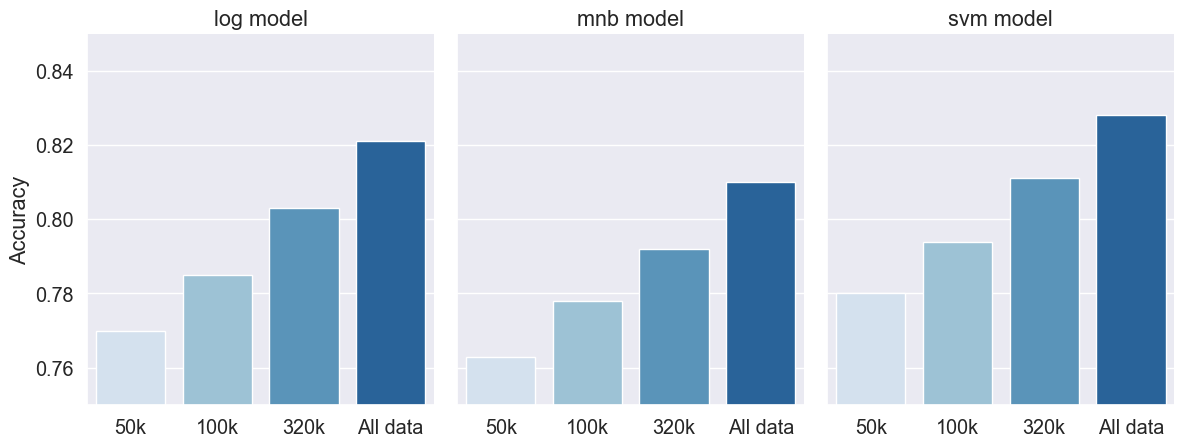

In [45]:
plt.figure(figsize=(5, 5))
g = sns.catplot(x='size',
                y='accuracy',
                col='model',
                data=results_,
                kind='bar',
                palette="Blues",
                height=5,
                aspect=.8)
g.set_axis_labels("", "Accuracy")
g.set_xticklabels(["50k", "100k", "320k", 'All data'])
g.set_titles("{col_name} {col_var}")
g.set(ylim=(0.75, 0.85));

In [47]:
data_dl = {'model': ['LSTM_1', 'LSTM_2', 'LSTM_3', 'LSTM_4'],
           'accuracy': [0.8334903717041016, 0.833044707775116, 0.8330681324005127, 0.8334356546401978]}
results_dl_ = pd.DataFrame.from_dict(data_dl)

<Figure size 500x500 with 0 Axes>

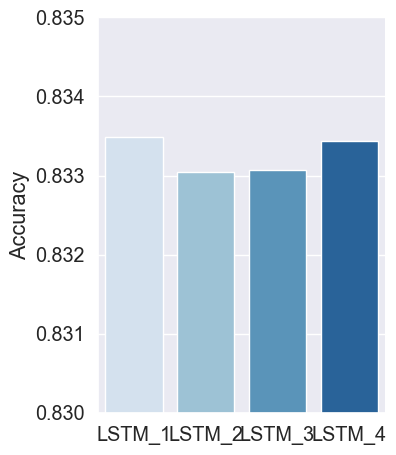

In [61]:
plt.figure(figsize=(5, 5))
g = sns.catplot(x='model',
                y='accuracy',
                data=results_dl_,
                kind='bar',
                palette="Blues",
                height=5,
                aspect=.8)
g.set_axis_labels("", "Accuracy")
g.set_xticklabels(["LSTM_1", "LSTM_2", "LSTM_3", 'LSTM_4'])
g.set(ylim=(0.83, 0.835));

# V. Conclusion

This project represents our final class work in this Machine Learning course. We applied most of the methods and models seen in class in order to get the best predictive performance we could. Various data preprocessing methods were tried but none of them ended up increasing our predictive performance. A high number of models and optimization led us towards this final score of about 83% of sentiment prediction using the Support Vector Machine model. Many attempts at using RNN or CNN or alternative models such as BERT were unsuccessful in this case, with prediction scores a bit lower than our conventional model. 

# VI. Appendix

### Word embeddings

In [32]:
from gensim.models import Word2Vec  # https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import FastText  # https://radimrehurek.com/gensim/models/fasttext.html
import gensim.downloader as api


def vectorize_tweet(tweet, model):
    # Get vector representation for each word and average them to get the tweet vector
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    if not vectors:
        return None
    return sum(vectors) / len(vectors)

In [34]:
# Keep only user, text and emotion class
emote = emote[['emotion', 'user', 'text']] 
#emote_ = emote[['emotion', 'user', 'text', 'text_clean']] # model from the class project
#emote = emote[['emotion', 'user', 'text', 'date']] # should have done this

emote_50 = emote[:50000]   #  50.000 first obs
emote_100 = emote[:100000] # 100.000 first obs
emote_320 = emote[:320000] #  about 1/4 of obs
emote_640 = emote[:640000] #  about 1/2 of obs

NameError: name 'emote_' is not defined

In [ ]:
import gensim.downloader as api

glove_model = api.load('glove-twitter-25')
sample_glove_embedding = glove_model['computer']

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api

v2w_model = v2w_model = api.load('word2vec-google-news-300')
sample_word2vec_embedding = v2w_model['computer']

In [ ]:
# Without text_clean

data = emote_50_
w2v_model = Word2Vec(sentences=(emote_50.text + emote_50.user),
                     vector_size=100,
                     window=5,
                     min_count=0,
                     workers=4)

# Vectorize all tweets
X_w2v = [
    vectorize_tweet(tweet, w2v_model)
    for tweet in (emote_50.text + emote_50.user)
]

In [ ]:
# Without text preprocess

X_train, X_test, y_train, y_test = train_test_split(X_w2v,
                                                    data.emotion,
                                                    test_size=0.2,
                                                    random_state=37)

logreg = LogisticRegression(C=0.9, solver='lbfgs', penalty='l2')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat,
    fmt='d',
    cbar=False,
    annot=True,
    #square=True,
    cmap=plt.cm.Blues,
    xticklabels=('Negative', 'Positive'),
    yticklabels=('Negative', 'Positive'))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print('Accuracy: ', logreg.score(X_test, y_test))

In [ ]:
# With text_clean

data = emote_50_
w2v_model = Word2Vec(sentences=(data.text_clean + data.user),
                     vector_size=100,
                     window=5,
                     min_count=1,
                     workers=4)

# Vectorize all tweets
X_w2v = [
    vectorize_tweet(tweet, w2v_model)
    for tweet in (data.text_clean + data.user)
]

In [ ]:
# Without text preprocess

X_train, X_test, y_train, y_test = train_test_split(X_w2v,
                                                    data.emotion,
                                                    test_size=0.2,
                                                    random_state=37)

logreg = LogisticRegression(C=0.9, solver='lbfgs', penalty='l2')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat,
    fmt='d',
    cbar=False,
    annot=True,
    #square=True,
    cmap=plt.cm.Blues,
    xticklabels=('Negative', 'Positive'),
    yticklabels=('Negative', 'Positive'))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print('Accuracy: ', logreg.score(X_test, y_test))

In [ ]:
data = emote_50_
ft_model = FastText(sentences=(data.text + data.user), min_count=0)

# Vectorize all tweets
X_ft = [vectorize_tweet(tweet, ft_model) for tweet in (data.text + data.user)]

In [ ]:
# Without text preprocess

X_train, X_test, y_train, y_test = train_test_split(X_ft,
                                                    data.emotion,
                                                    test_size=0.2,
                                                    random_state=37)

logreg = LogisticRegression(C=0.9, solver='lbfgs', penalty='l2')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat,
    fmt='d',
    cbar=False,
    annot=True,
    #square=True,
    cmap=plt.cm.Blues,
    xticklabels=('Negative', 'Positive'),
    yticklabels=('Negative', 'Positive'))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print('Accuracy: ', logreg.score(X_test, y_test))

while TF-IDF focuses on the frequency and uniqueness of words in a document and represents text as sparse vectors, word embeddings focus on capturing semantic relationships between words in a continuous vector space. TF-IDF is simpler and interpretable, but it may not capture complex semantic nuances. On the other hand, word embeddings provide dense and context-aware representations, allowing models to understand the meaning and context of words in a more sophisticated manner. 

## Preprocessing Effectiveness

One way of getting increasing the performance of a model is to apply preprocessing methods on the text. Let's see if it makes a difference here. <br>
Here's a first logistic model fit on 50 000 observations, with preprocessing :

In [68]:
# Define the train and test sets (50 000 observations)
X_train, X_test, y_train, y_test = train_test_split((emote_50.text_clean + emote_50.user), emote_50.emotion, test_size=0.1, random_state=37)

# Define the parameters to tune
parameters_log = {
    # 'vect__max_df': (0.5,),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'model__C': (0.5, 0.75, 1.0),
    'model__penalty': ('l2','l1'),
}

# Perform the grid search
GridSearch_(X_train, y_train, parameters = parameters_log, model = LogisticRegression(solver='liblinear'))
# Acc:0.756 without symbols/stopwords; Acc:0.756 without symbols/stopwords/stemming

Performing grid search...
pipeline: ['vect', 'tfidf', 'model']
parameters:
{'model__C': (0.5, 0.75, 1.0),
 'model__penalty': ('l2', 'l1'),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
done in 55.005s

Best score: 0.756
Best parameters set:
	model__C: 1.0
	model__penalty: 'l2'
	vect__ngram_range: (1, 2)


We achieved a prediction score of 76% using logistic regression on 50 000 observations. Let's now compare this score with the one using the unprocessed data :

In [54]:
# Define the train and test sets (50 000 observations)
X_train, X_test, y_train, y_test = train_test_split((emote_50.text + emote_50.user), emote_50.emotion, test_size=0.1, random_state=37)

# Define the parameters to tune
parameters_log = {
    # 'vect__max_df': (0.5,),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'model__C': (0.5, 0.75, 1.0),
    'model__penalty': ('l2','l1'),
}

# Perform the grid search
GridSearch_(X_train, y_train, parameters = parameters_log, model = LogisticRegression(solver='liblinear'))

Performing grid search...
pipeline: ['vect', 'tfidf', 'model']
parameters:
{'model__C': (0.5, 0.75, 1.0),
 'model__penalty': ('l2', 'l1'),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
done in 91.751s

Best score: 0.773
Best parameters set:
	model__C: 1.0
	model__penalty: 'l2'
	vect__ngram_range: (1, 2)


We achieved a prediction score of 77.7% with 50 000 observations using logistic regression on unprocessed data. We observe that the preprocess is actually hurting our prediction accuracy.

**In this case, we fitted the same models once without any kind of preprocess and a second time using various preprocess methods. Selecting each of these methods separately (not shown here) guided us in the same direction. We found no preprocess techniques worth adding in the aim of better prediction accuracy for this dataset.**

# Marc w2vec

In [ ]:
from gensim import downloader

In [ ]:
w2v = gensim.downloader.load('glove-twitter-200')

In [ ]:
def tweet_vectorizer(tweet):
    tweet_split = tweet.split()
    tweet_vec = np.zeros(200).astype("float32")
    err_count = 0
    for j in range(len(tweet_split)):
        try:
            tweet_vec = tweet_vec + w2v[tweet_split[j]]
        except:
            err_count = err_count + 1
            pass
    if err_count == len(tweet_split):
        pass
    else:
        tweet_vec = tweet_vec / (len(tweet_split) - err_count)
    return(tweet_vec)

In [ ]:
X_w2v = np.zeros((1600000, 200))
w2v_load = data["text_a"].str.replace('[^\w\s]','')
for i in range(len(w2v_load)):
    X_w2v[i] = tweet_vectorizer(w2v_load[i])

## BERT 
This is an attempt at implementing a sophisticated model trained by Google, BERT. 
Unfortunately, BERT model was computationaly too costly and so too difficult for us to implement looking at our time and computation power restrictions. Here's how it would have gone with more resources :

## EDA and Preprocessing

In [ ]:
#pip install torch

In [56]:
import torch 
from tqdm.notebook import tqdm

In [57]:
df = pd.read_csv("MLUnige2021_train.csv")
df.head()

,Id,emotion,tweet_id,date,lyx_query,user,text
0,0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...
1,1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...
2,2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...
3,3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...
4,4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...


In [58]:
df50 = df.sample(1000)
df50['id'] = range(1, len(df50) + 1)
df50.head()

,Id,emotion,tweet_id,date,lyx_query,user,text,id
726359,726359,1,1548913184,Fri Apr 17 22:22:39 PDT 2009,NO_QUERY,justmikeyhrc,Sleep mode initiated...long day ahead. Hopeful...,1
22139,22139,1,1978778261,Sun May 31 00:26:11 PDT 2009,NO_QUERY,babybyndi,"I love it when he wears Express clothes. Yumm,...",2
1047379,1047379,1,2179011339,Mon Jun 15 08:31:13 PDT 2009,NO_QUERY,eyulo,beautiful day in the city it pays to live in ...,3
716599,716599,0,2186036482,Mon Jun 15 18:15:53 PDT 2009,NO_QUERY,Beejangles,Grocery shopping. Alone no one ever comes wit...,4
332822,332822,0,2065610910,Sun Jun 07 08:56:54 PDT 2009,NO_QUERY,LucyMarie85,@AnnaSaccone i know but its just rude ahhh we...,5


In [59]:
df50.set_index('id', inplace=True)
df50 = df50[['emotion', 'text']]
df50.head()

,emotion,text
id,,
1,1,Sleep mode initiated...long day ahead. Hopeful...
2,1,"I love it when he wears Express clothes. Yumm,..."
3,1,beautiful day in the city it pays to live in ...
4,0,Grocery shopping. Alone no one ever comes wit...
5,0,@AnnaSaccone i know but its just rude ahhh we...


In [60]:
df50.text.iloc[0]

'Sleep mode initiated...long day ahead. Hopefully new things to share tomorrow. Anyone want to see anything at the MK, let me know. '

## Train test split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    df50.index.values,
    df50.emotion.values,
    test_size = 0.15, random_state = 42) # no stratification since balanced

In [62]:
# Create a column in df50 saying whether data is in training or test set.
df50['data_type'] = ['not_set']*df50.shape[0]

In [63]:
df50.loc[X_train, 'data_type'] = 'train'
df50.loc[X_test, 'data_type'] = 'test'

In [64]:
df50.groupby(['emotion', 'data_type']).count()

text
emotion data_type      
0       test         75
        train       434
1       test         75
        train       416

## Loading Tokenizer and Encoding the Data

In [ ]:
#pip install transformers

In [67]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [68]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
) #uncased for all lowercase data

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [69]:
encoded_data_train = tokenizer.batch_encode_plus(
    df50[df50.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask = True,
    pad_to_max_length=True,
    max_length=110,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df50[df50.data_type=='test'].text.values,
    add_special_tokens=True,
    return_attention_mask = True,
    pad_to_max_length=True,
    max_length=110,
    return_tensors='pt'
)

# input for BERT to train
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
emotion_train = torch.tensor(df50[df50.data_type=='train'].emotion.values)

# input for BERT to test
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
emotion_test = torch.tensor(df50[df50.data_type=='test'].emotion.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\rened\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [70]:
# BERT's datatsets 
dataset_train = TensorDataset(input_ids_train, attention_masks_train, emotion_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, emotion_test)

## Setting up BERT pretrained model

In [71]:
from transformers import BertForSequenceClassification

In [72]:
# each tweet is a sequence that will be classified positive or negative emotion
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(df50.emotion.unique()), #how many output it can have 
    output_attentions=False, 
    output_hidden_states=False #doesn't show output 
)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Creating Data Loaders

In [73]:
# Data loaders offer a nice way to iterate through our dataset in batches
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [74]:
batch_size = 4 #32 previously but we have limited memory on these machines

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=32 #back to 32 because we don't have many computations on the test set 
)
#our dataset is now in a dataloader

## Setting up Optimizer and Scheduler

In [75]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [76]:
#optimizer (ADAM) is a way to optimize our weights 
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, #recommended by the original paper to be between 2e-5 and 5e-5, can cross-validate this hyper-parameter
    eps=1e-8
)

In [77]:
epochs = 5 #can be cross validated

#scheduler defines our learning rate and how it changes through each epoch 

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, #default
    num_training_steps= len(dataloader_train)*epochs #defines how many times learning rate changes
)

## Defining our Performance Metrics

In [78]:
from sklearn.metrics import f1_score


def f1_score_func(preds, emotion):
    preds_flat = np.argmax(preds, axis=1).flatten()
    emotion_flat = emotion.flatten()
    return f1_score(emotion_flat, preds_flat, average = 'weighted') #can put average=macro

def accuracy_per_class(preds, emotion):
    emotion_dict_inverse = {1, 0}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    emotion_flat = emotion.flatten()
    
    for emotion in np.unique(emotion_flat):
        y_preds = preds_flat[emotion_flat==emotion]
        y_true = emotion_flat[emotion_flat==emotion]
        print(f'Class:{emotion_dict_inverse[emotion]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [79]:
import random 

seed_test=42 #can try with seed 17 also (modify upper too)
random.seed(seed_test)
np.random.seed(seed_test)
torch.manual_seed(seed_test)
torch.cuda.manual_seed_all(seed_test) #useful if we use a GPU

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device) #best when cuda

cpu


In [81]:
def evaluate(dataloader_test):
    
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_test):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'inputs_ids': batch[0],
              'attention_mask': batch[1],
                     'labels': batch[2]}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        
        logits = logits.detach().cpu().numpy()
        emotion_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(emotion_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_test)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    return loss_val_avg, predictions, true_vals
        

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, disable=False) #to see how many batched have been trained and how many remain
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
             'input_ids': batch[0],
             'attention_mask': batch[1],
             'labels': batch[2]
         }
            
        outputs = model(**inputs)
         
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total / len(dataloader)
    tqdm.write(f'Training loss:{loss_train_avg}')
    
    test_loss, predictions, true_vals = evaluate(dataloader_test)
    test_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Test loss:{test_loss}')
    tqdm.write(f'F1 score (weighted): {test_f1}')

## Loading and Evaluating model

In [ ]:
emotion_dict = {0, 1}
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                     num_labels = len(emotion_dict),
                                                     output_attentions = False, 
                                                     output_hidden_states = False)

In [84]:
model.to(device)
pass

In [ ]:
model.load_state_dict(torch.load('Models/finetuned_bert_epoch_1_gpu_trained.model',
                                map_location=torch.device('cpu')))

In [ ]:
_, predictions, true_vals = evaluate(dataloader_test)

In [ ]:
accuracy_per_class(prediction, true_vals)